# SRSP Laser Lab Data and Analysis
The notebook contains data and analysis from the laser lab at NCCU in the Mary Townes Science Building in room 1149 during summer 2019. The programming is written by Akash Mullick and Chris Knotek, working with Dr. Marvin H Wu.  

The following program contains data from a photoluminecense expirement on WSe<sub>2</sub> and maps the diffusion through the material as a function of time. 

In [1]:
import numpy as np 
from pylab import imshow, show, jet #used for heat map
import matplotlib.pyplot as plt
import pandas as pd

data = np.loadtxt("./all41by41.txt", float) #load photoluminecense data
new_data = []

**Heat maps of intensity in space graphed for different time points**

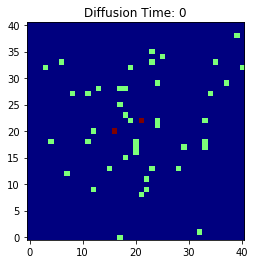

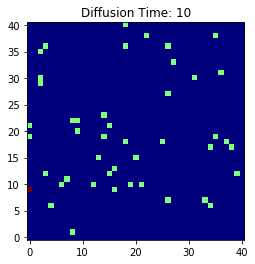

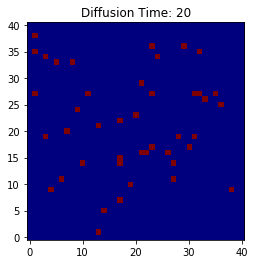

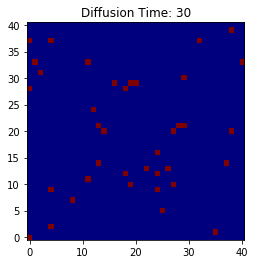

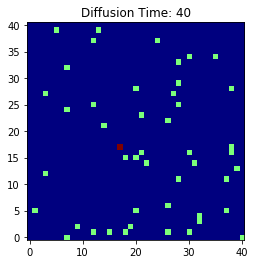

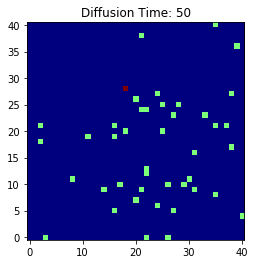

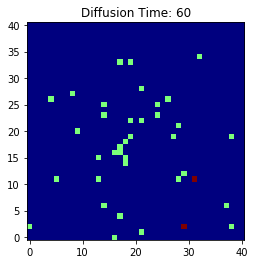

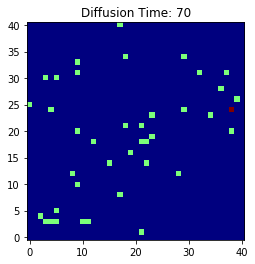

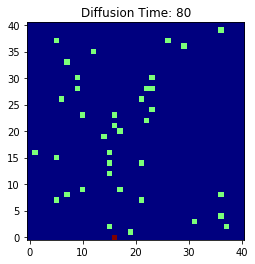

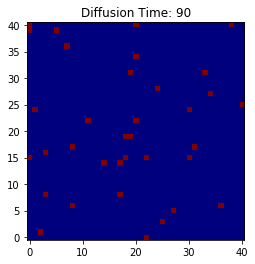

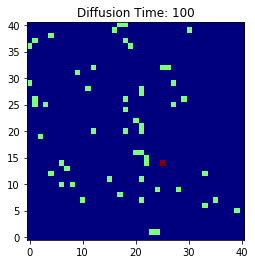

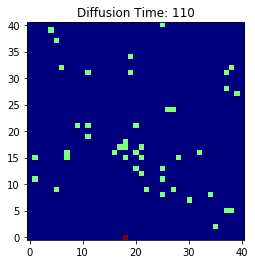

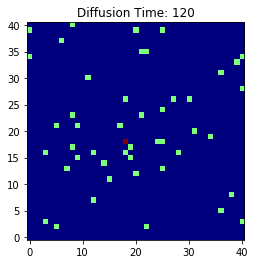

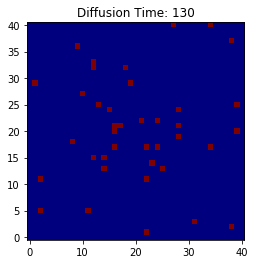

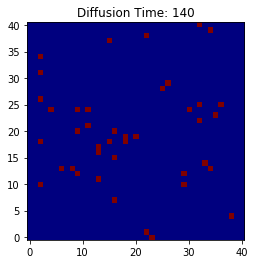

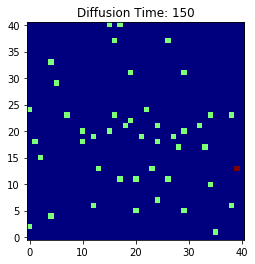

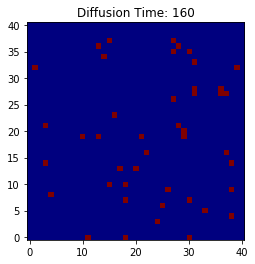

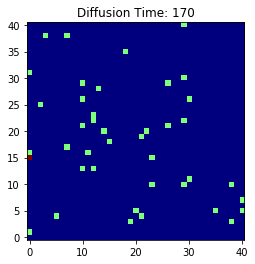

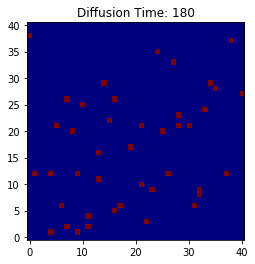

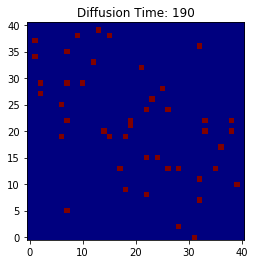

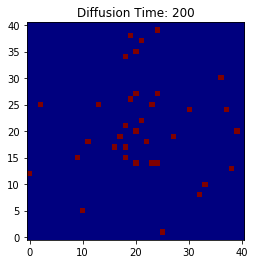

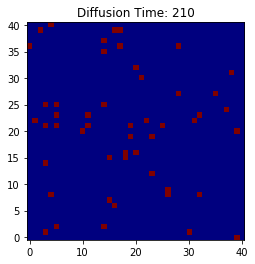

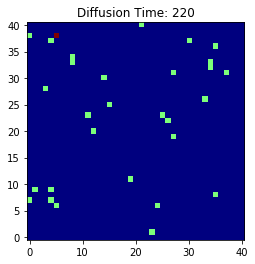

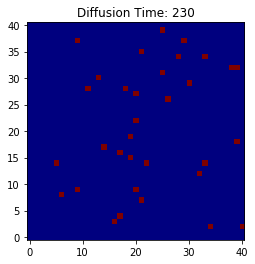

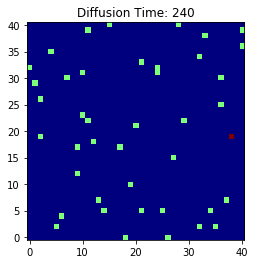

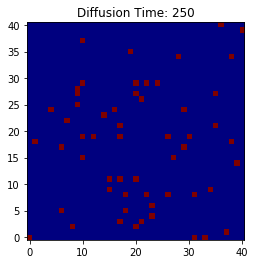

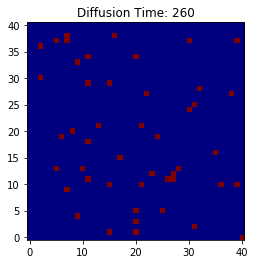

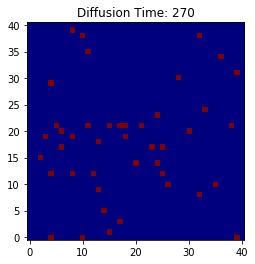

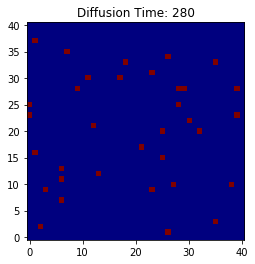

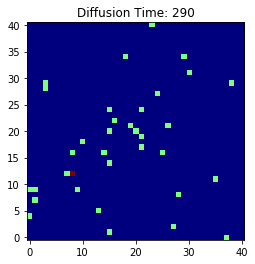

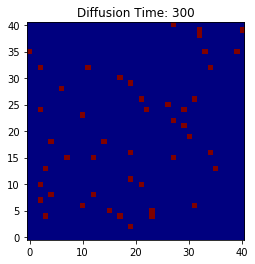

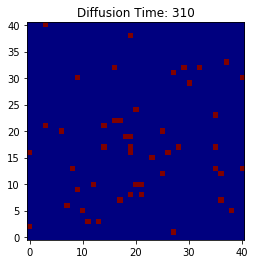

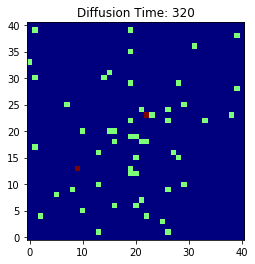

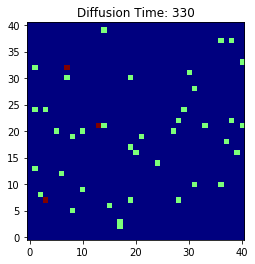

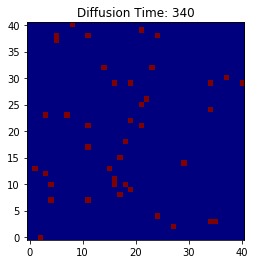

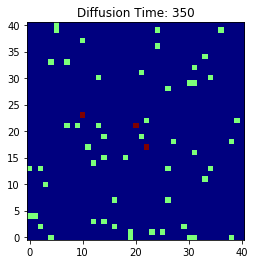

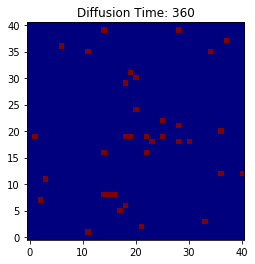

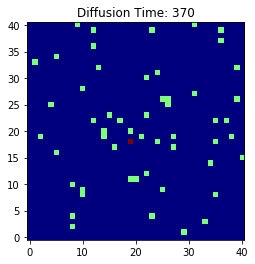

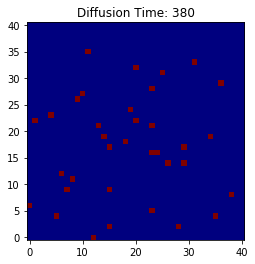

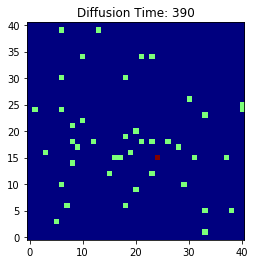

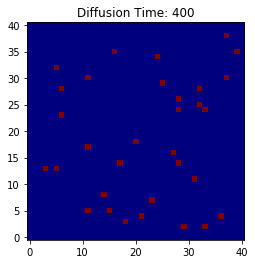

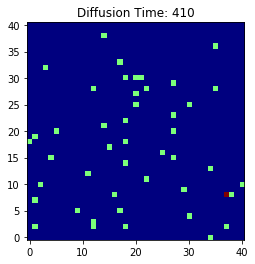

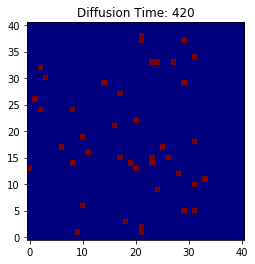

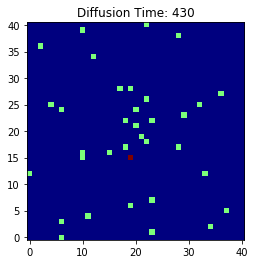

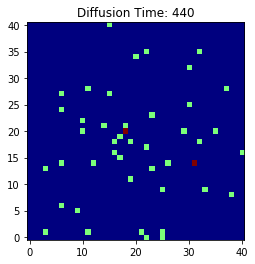

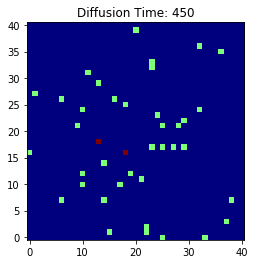

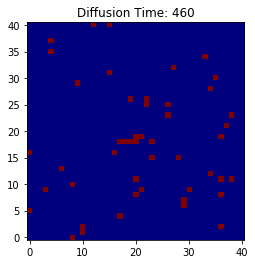

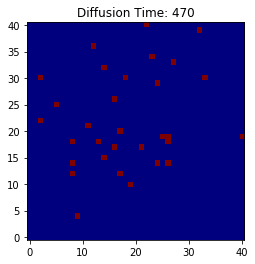

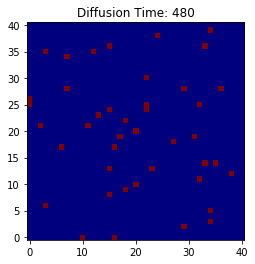

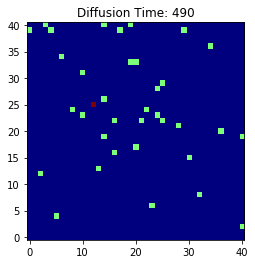

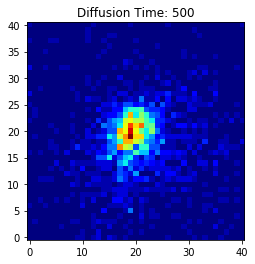

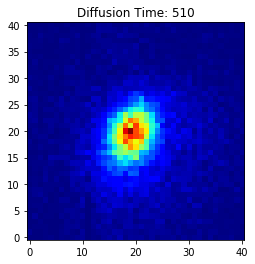

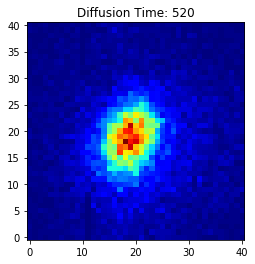

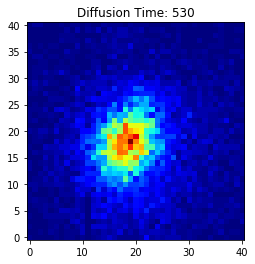

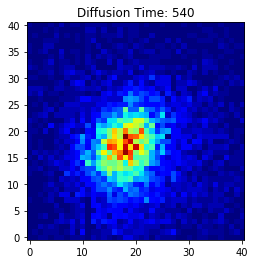

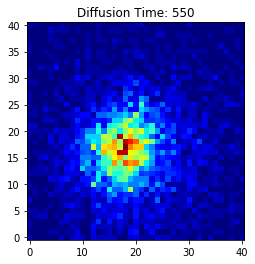

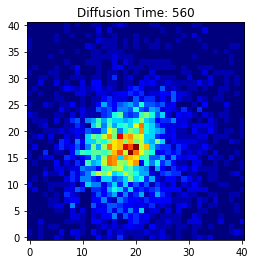

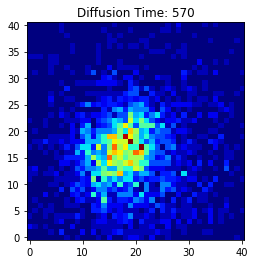

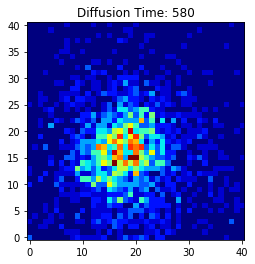

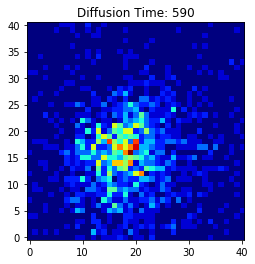

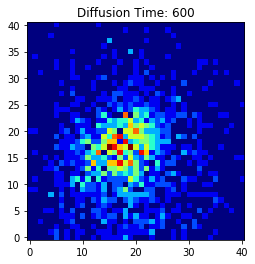

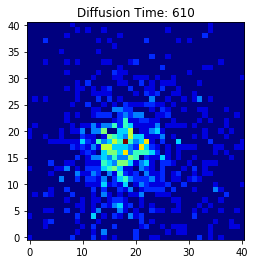

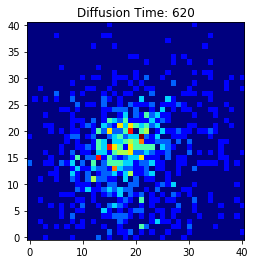

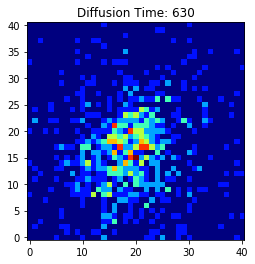

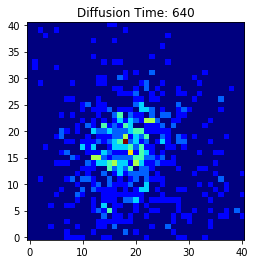

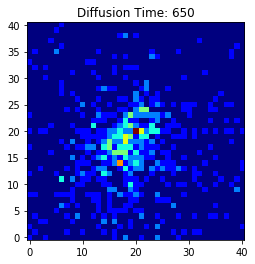

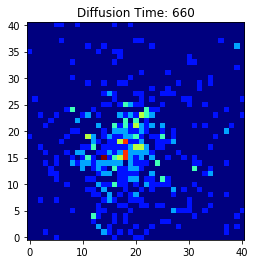

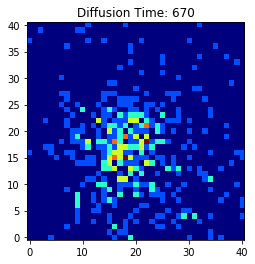

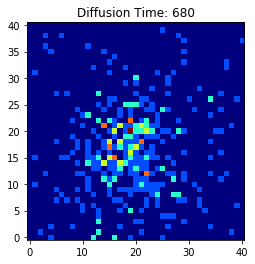

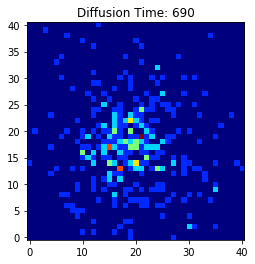

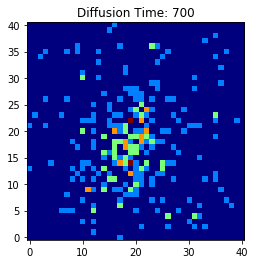

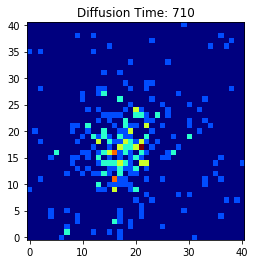

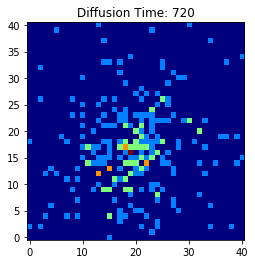

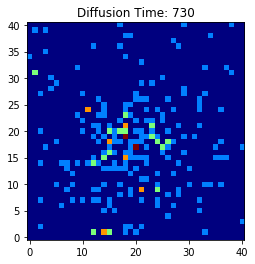

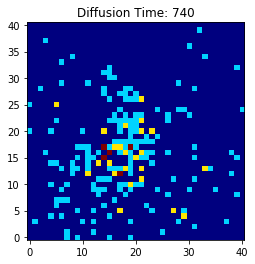

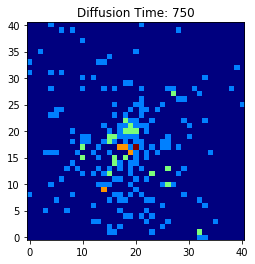

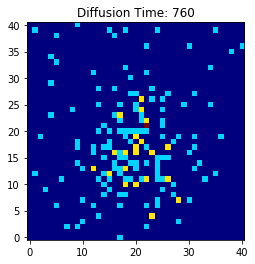

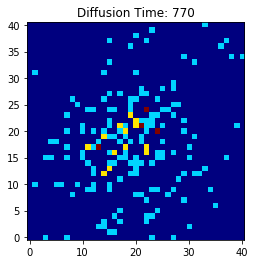

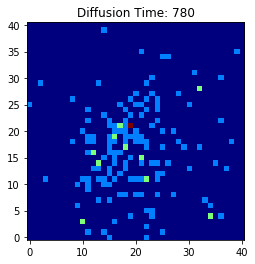

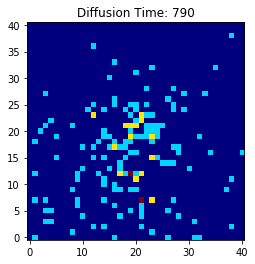

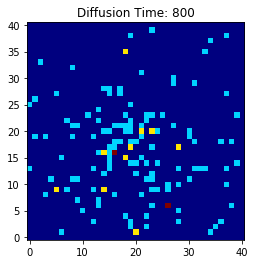

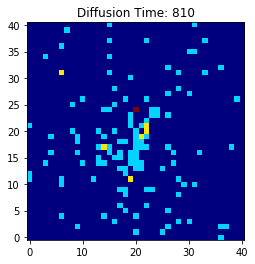

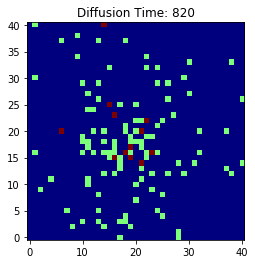

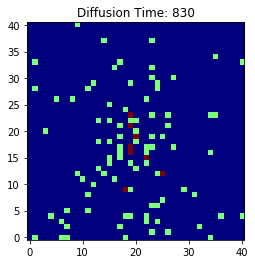

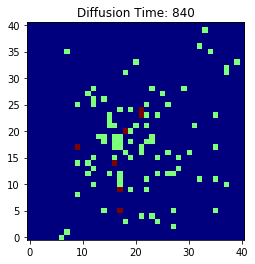

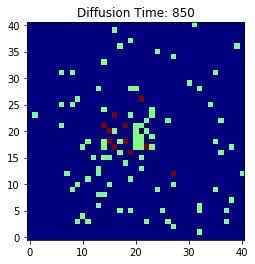

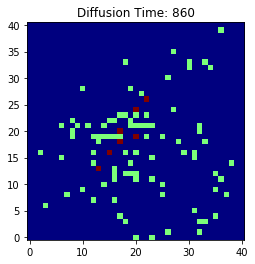

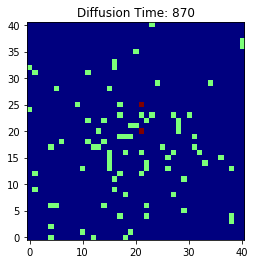

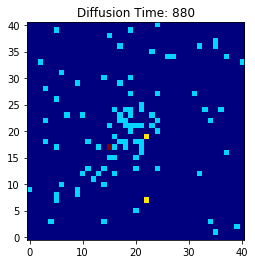

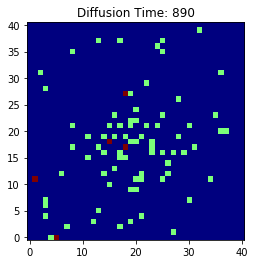

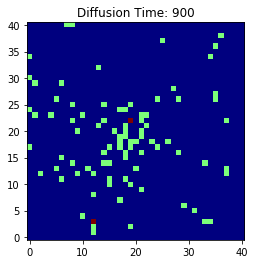

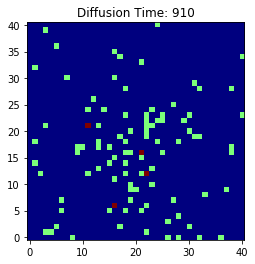

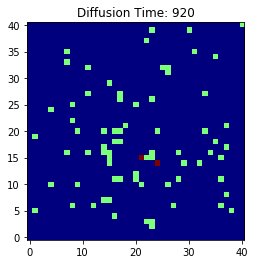

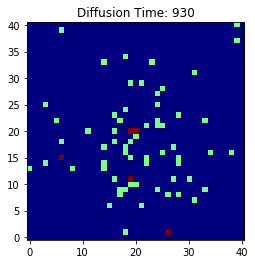

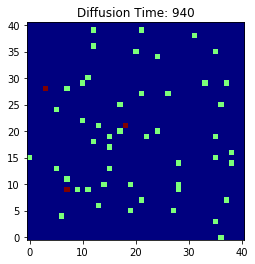

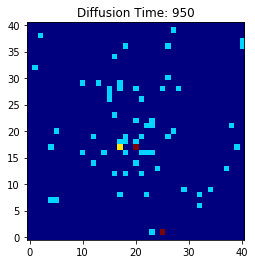

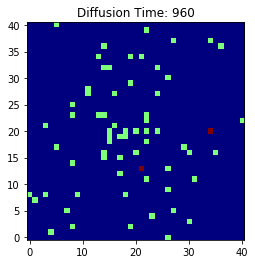

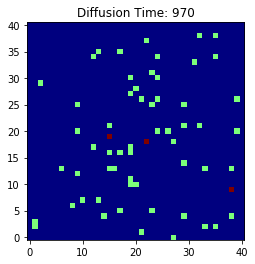

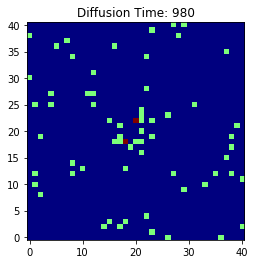

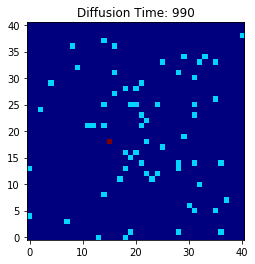

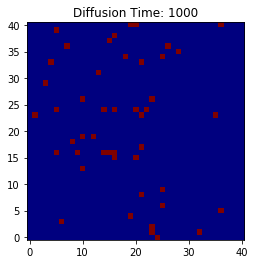

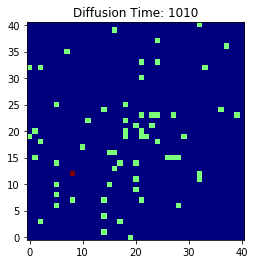

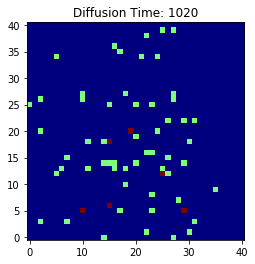

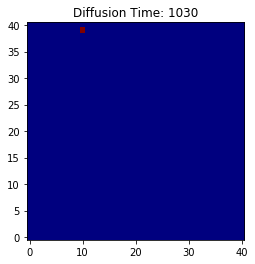

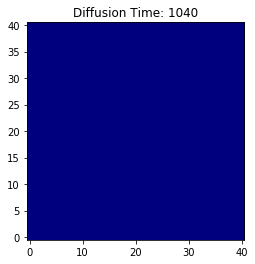

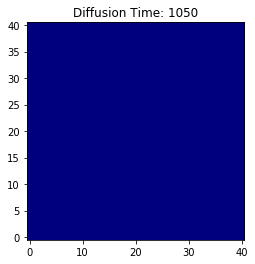

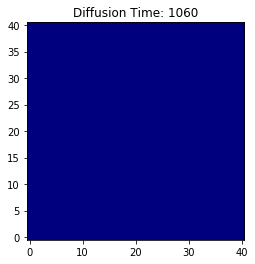

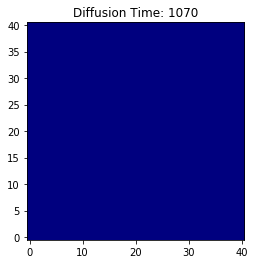

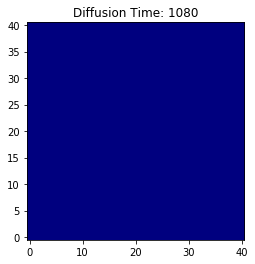

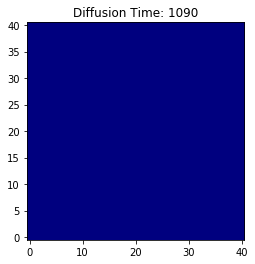

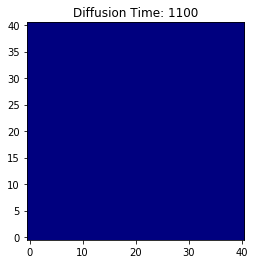

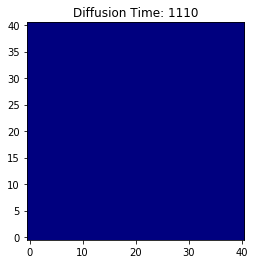

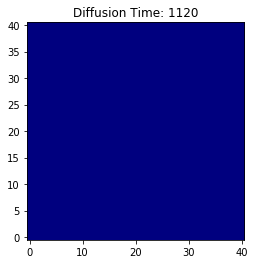

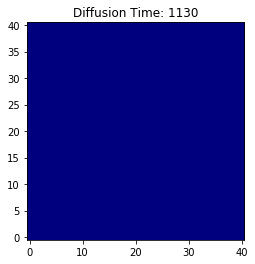

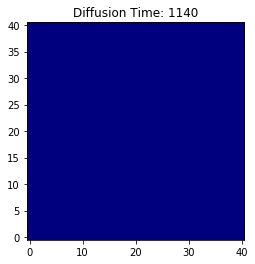

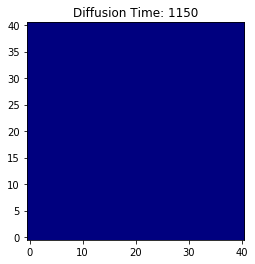

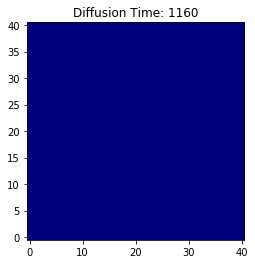

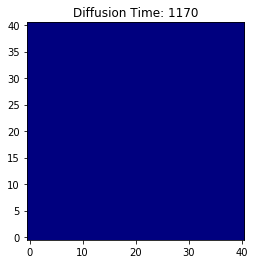

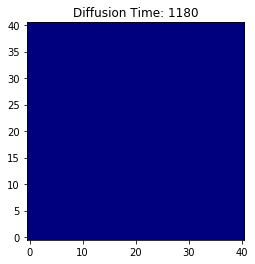

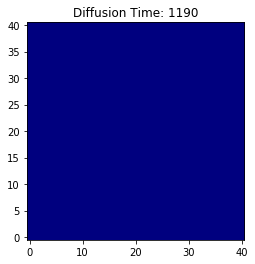

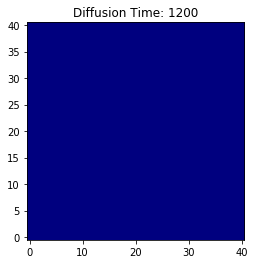

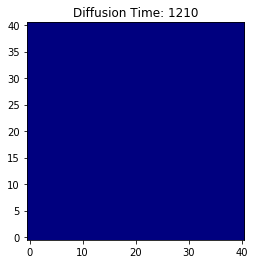

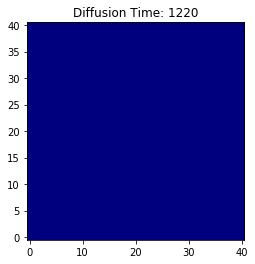

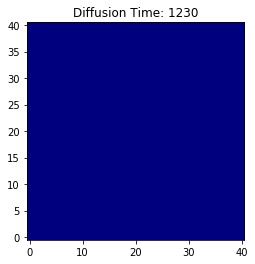

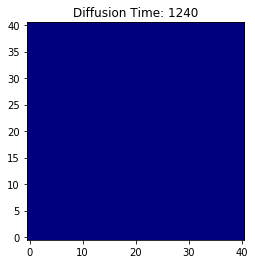

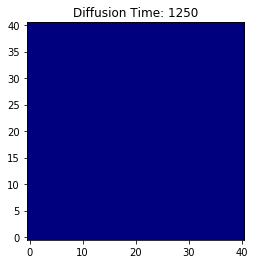

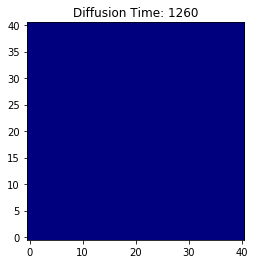

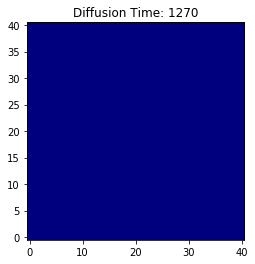

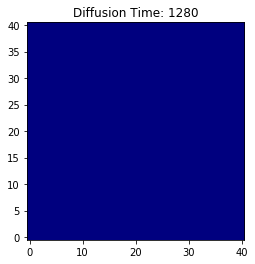

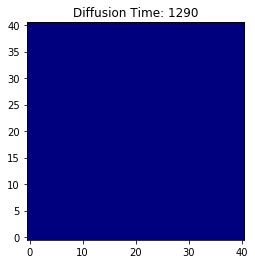

In [2]:
#array to take 41x53177 data structure and plot 1297 41x41 pictures, repesenting a spatial picture over time
for n in range(1297):
    #only do every 10 time steps 
    if n%10 != 0:
        continue
    #create new 41x41 array for current time step
    for i in range(41):
        new_data.append(data[n*41+i])
     #create density plot
    imshow(new_data, origin = "lower")
    plt.title('Diffusion Time: ' + str(n))
    jet() #change color for clarity
    show()
    new_data = [] #reset data

**Creates graph of average width of area that is intense over time**

In [3]:
#creates 1297 1d (41x1) arrays of data of center of diffusion from 41x41 picture
for n in range(1, 1297, 1):
    globals()["data1d_" + str(n)] = data[41*n + 20]

In [4]:
from lmfit import  Model

width = [] #array for average width of gaussian curve of each 1d strip over time
x = np.linspace(1, 41, 41) 
#gaussian function to fit to
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))
#run width calculation only from start to end of expirement
for n in range(450, 600, 1):
    #name data with the iterator
    y = globals()["data1d_" + str(n)]

    gmod = Model(gaussian)
    result = gmod.fit(y, x=x, amp=5, cen=5, wid=1)

    array = [] #stores fit reports
    array.append(result.fit_report())
    #goes through fit report to extract width of curve for each time
    for i in range(1, 1000):
        #width signaled by "wid: ", extracts characters following it
        if array[0][i] == "w":
            width.append(float(str(array[0][i+6]) + str(array[0][i+7]) + str(array[0][i+8]) + str(array[0][i+9]) + str(array[0][i+10]) + str(array[0][i+11]) + str(array[0][i+12])))
            break

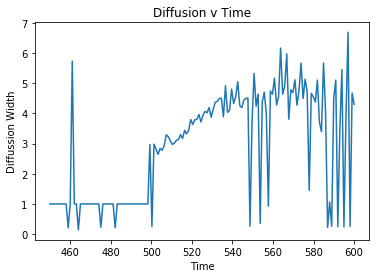

In [5]:
widtht = np.linspace(450, 600, 150) #time values for data being looked at
plt.xlabel("Time")
plt.ylabel("Diffussion Width")
plt.title("Diffusion v Time")
plt.plot(widtht, width) #plot width of curve v time

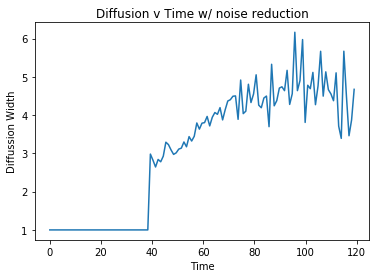

In [6]:
reg = []
i = 0
#takes width graph and gets rid of points less than 1/2 of the previous point
while i < (len(width) - 1):
    #if the point is too low, do not add it to new array 
    if width[i]/width[i+1] > 2:
        i += 2 #skip over bad point
        continue
    #add good points
    reg.append(width[i])
    i += 1
#plot width without noise
plt.xlabel("Time")
plt.ylabel("Diffussion Width")
plt.title("Diffusion v Time w/ noise reduction")
avgt = np.linspace(0, len(reg), len(reg))
plt.plot(avgt, reg)

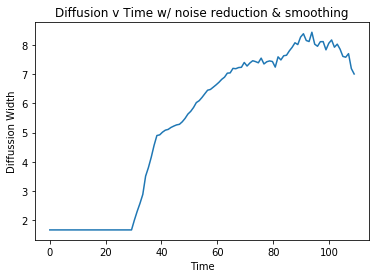

In [7]:
#make array of running average of width w/o noise to smooth it out
avg = []
for i in range(len(reg)-10):
    num = 0
    #average 5 points ahead and beind current point
    for n in range(5):
        num += reg[i + 5 + n]
        num += reg[i + 5 - n]
    avg.append(num/6)
#plot smoothed and noise reduced graph
plt.xlabel("Time")
plt.ylabel("Diffussion Width")
plt.title("Diffusion v Time w/ noise reduction & smoothing")
plt.plot(np.linspace(0, len(avg), len(avg)), avg)

**Center Intensity v Time** <br>
The intensity of the center pixel (from the original data set) v time is plotted and fitted to a double exponetial curve

In [8]:
#extract the center data point from the 1d data, already centered from the image
center = []
for i in range(1, 41, 1):
    globals()["point" + str(i)] = []
    globals()["background" + str(i) + "list"] = []
    globals()["background" + str(i)] = 0
for n in range(518, 700, 1):
    center.append(globals()["data1d_" + str(n)][20])
    #create array over time for every point across x axis of picture
    for i in range(1, 41, 1):
        globals()["point" + str(i)].append(globals()["data1d_" + str(n)][i])
#calculate background average
for i in range(1, 490, 1):
    for n in range(1, 41, 1):
        globals()["background" + str(n) + "list"].append(globals()["data1d_" + str(i)][n])
        globals()["background" + str(n)] += globals()["data1d_" + str(i)][n]
for i in range(1, 41, 1):
    globals()["background" + str(i) + "std"] = np.std(globals()["background" + str(n) + "list"])
    globals()["background" + str(i)] = globals()["background" + str(i)]/496

**This plots intensity of all pixels on row 20 v time:**

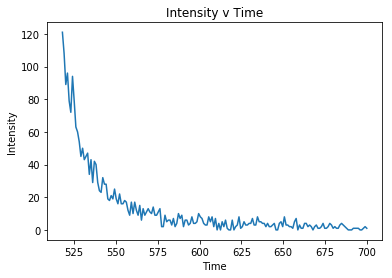

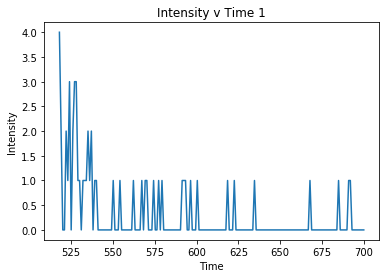

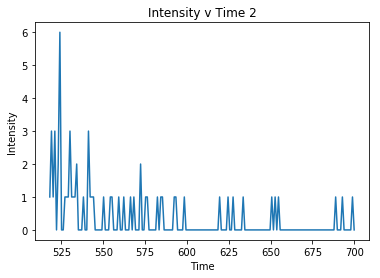

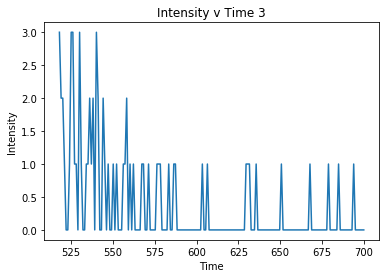

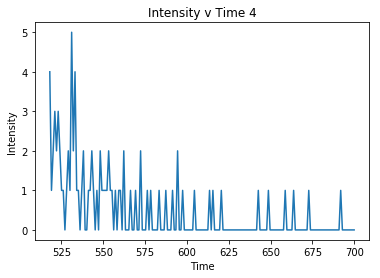

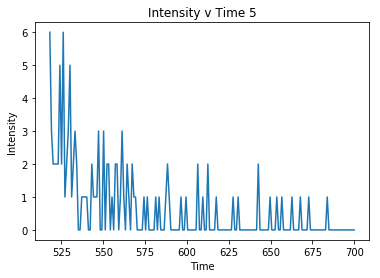

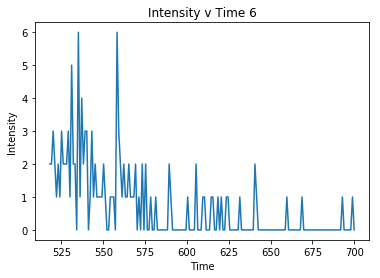

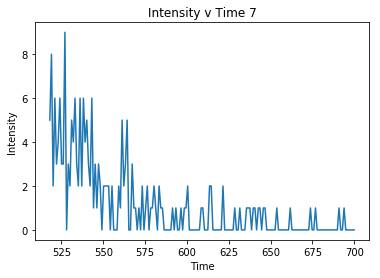

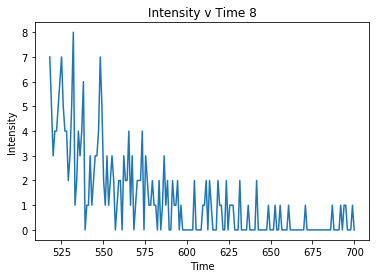

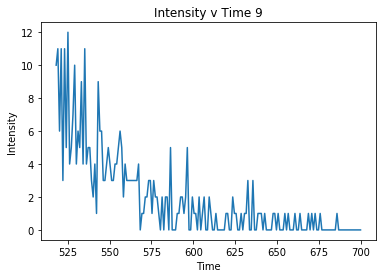

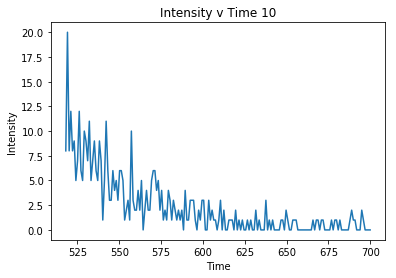

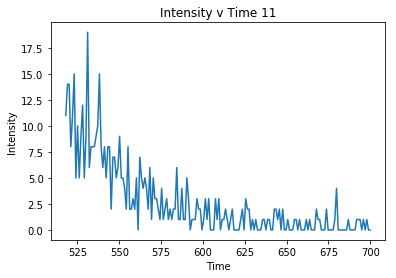

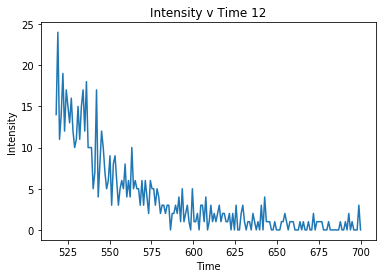

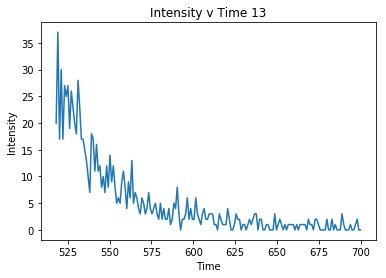

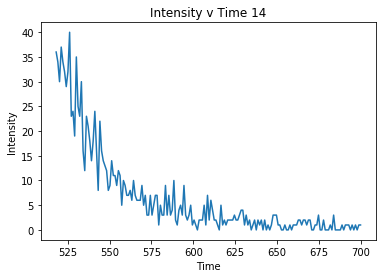

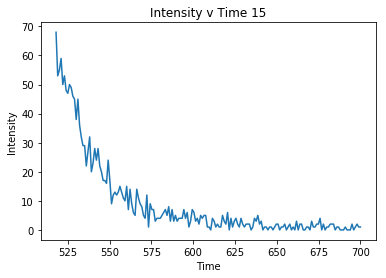

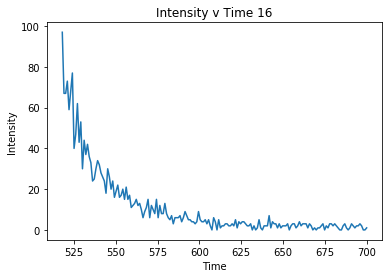

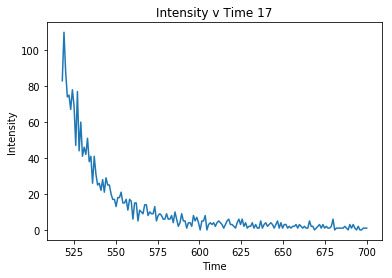

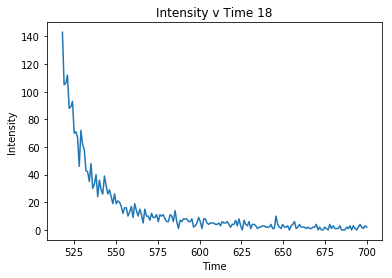

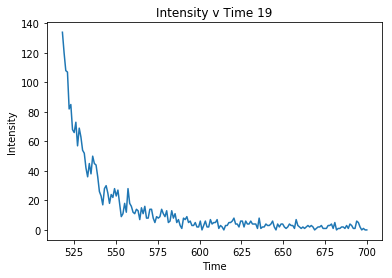

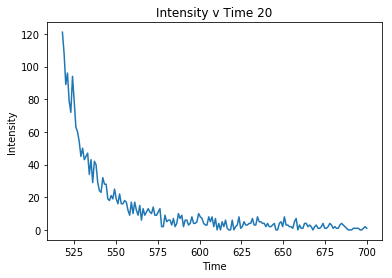

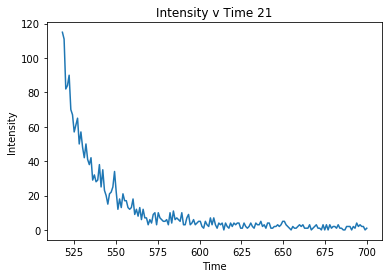

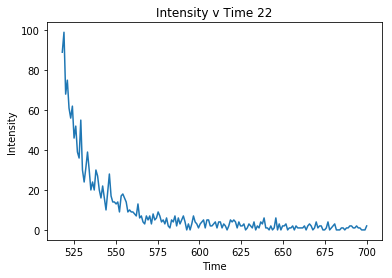

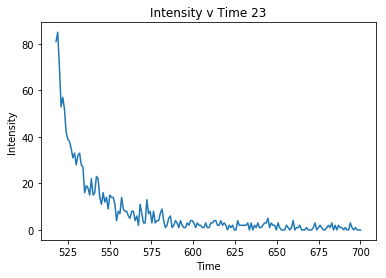

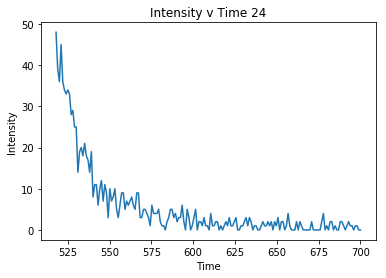

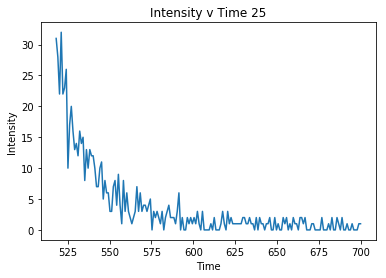

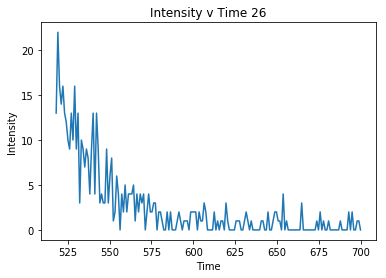

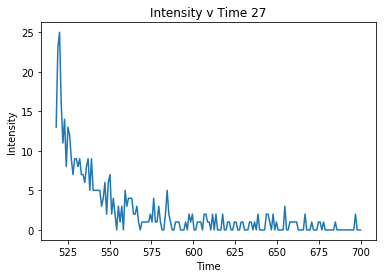

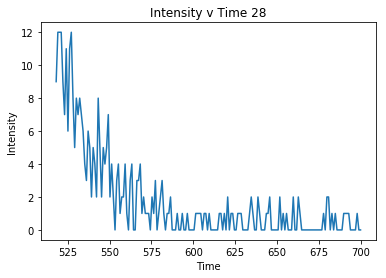

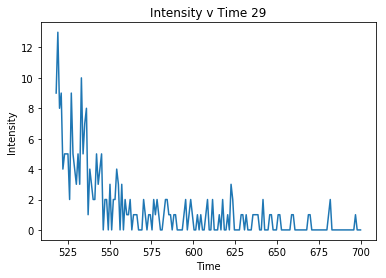

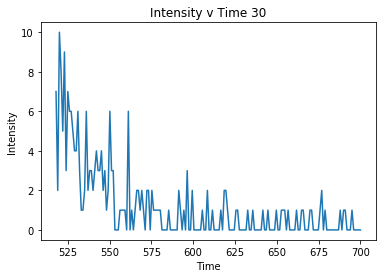

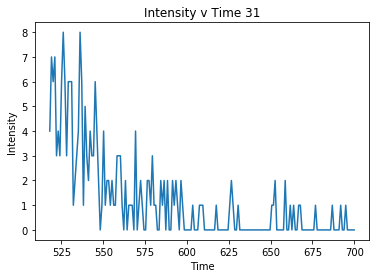

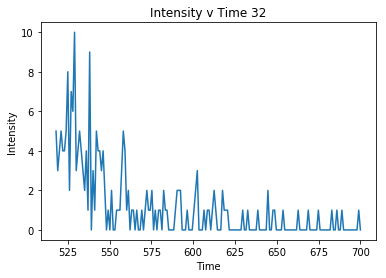

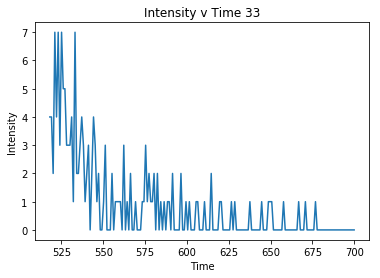

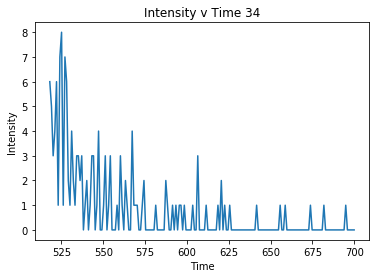

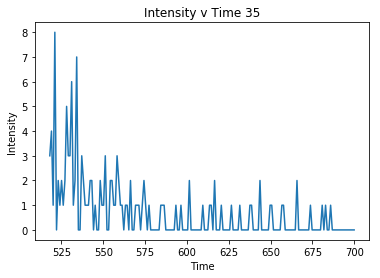

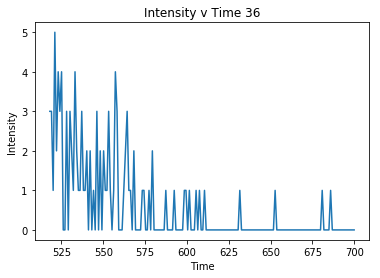

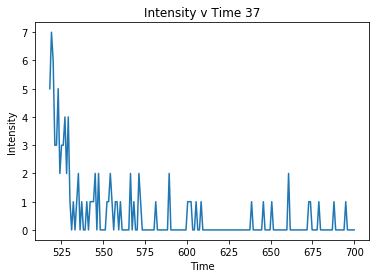

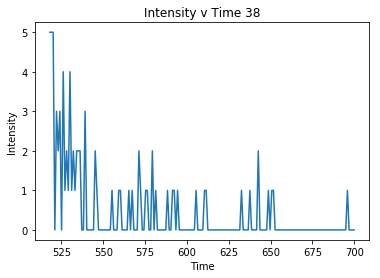

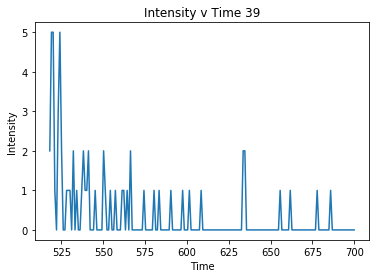

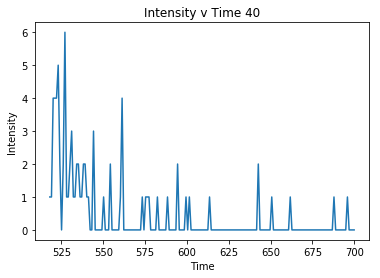

In [9]:
#plot the pixel intesity v time
xstuff = np.linspace(518, 700, 182)
plt.title("Intensity v Time")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.plot(xstuff, center)
show()

for i in range(1, 41, 1):
    plt.title("Intensity v Time " + str(i))
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.plot(xstuff, globals()["point" + str(i)])
    show()


**The following fits a double exponential to the center most pixel with equal weighting** <br>
The fit parameters are tau1 and tau2

Function: y = 0.075 + 59.0*e^(-(x-518)/7.062) + 59.0*e^(-(x-518)/29.494)


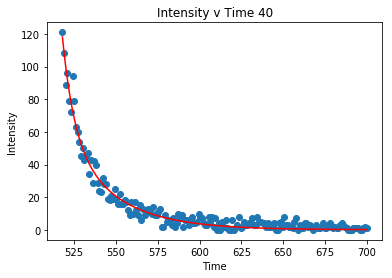

In [10]:
#fits a curve to the data
from pylab import *
from scipy.optimize import curve_fit

init = (data1d_518[20] + data1d_518[21])/2
x = xstuff #store the x data
y = center #store the y data

#define the function you would like to fit to
def func(x, tau1, tau2):
    return background20 + 0.5*init*np.exp(-(x-518)/tau1) + 0.5*init*np.exp(-(x-518)/tau2)
#store values from curve fit, give it (function, x vals, y vals, [initial vals of function constants])
popt, pcov = curve_fit(func, x, y, [25,25])
#print function in an easy to read way
print("Function: y = " + str(round(background20, 3)) + " + " + str(round(0.5*init, 3)) + "*e^" +  "(-(x-" + str(518) + ")/" + str(round(popt[0], 3)) + ") + " + str(round(0.5*init, 3)) + "*e^" +  "(-(x-" + str(518) + ")/" + str(round(popt[1], 3)) + ")")
#plot orgiginal data and fitted function
scatter(x,y)
plt.title("Intensity v Time " + str(i))
plt.xlabel("Time")
plt.ylabel("Intensity")
plot(x,func(x,*popt), 'r')
show()

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 182
    # variables        = 4
    chi-square         = 7785.80343
    reduced chi-square = 43.7404687
    Akaike info crit   = 691.601208
    Bayesian info crit = 704.417235
[[Variables]]
    a1:    103.539328 +/- 2.55333296 (2.47%) (init = 70)
    a2:    20.0000000 +/- 2.92283569 (14.61%) (init = 70)
    tau1:  18.8731097 +/- 0.88802901 (4.71%) (init = 20)
    tau2:  1.08977556 +/- 0.34284960 (31.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.865
    C(a1, a2)     = -0.838
    C(a1, tau2)   = -0.758
    C(a2, tau1)   =  0.732
    C(tau1, tau2) =  0.586
    C(a2, tau2)   =  0.517



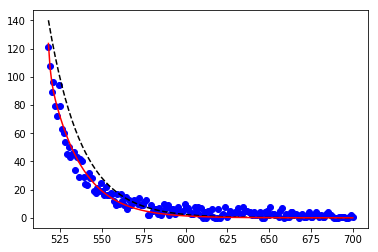

In [11]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model, Parameters

x = xstuff #store the x data
y = center #store the y data

def func(x, a1, a2, tau1, tau2):
        return background20 + a1*np.exp(-(x-518)/tau1) + a2*np.exp(-(x-518)/tau2)
    
weight = [.033*x for x in y] + background20std
gmodel = Model(func)
pars = Parameters()
pars.add('a1', value = 70, min = 20, max = 120)
pars.add('a2', value = 70, min = 20, max = 120)
pars.add('tau1', value = 20, min = 0, max = 75)
pars.add('tau2', value = 20, min = 0, max = 75)
result = gmodel.fit(y, pars, x=x, weights = weight)
print(result.fit_report())
plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 182
    # variables        = 2
    chi-square         = 19212.8801
    reduced chi-square = 106.738223
    Akaike info crit   = 851.997966
    Bayesian info crit = 858.405979
[[Variables]]
    a1:    114.870426 +/- 1.09354143 (0.95%) (init = 70)
    tau1:  15.6249414 +/- 0.43430983 (2.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.638

['16', '182', '2', '19212', '8801', '106', '738223', '851', '997966', '858', '405979', '1', '114', '870426', '1', '09354143', '0', '95', '70', '1', '15', '6249414', '0', '43430983', '2', '78', '20', '0', '100', '1', '1', '0', '638']


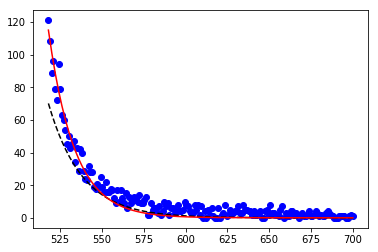

In [12]:
import re
x = xstuff #store the x data
y = center #store the y data

def func(x, a1, tau1):
        return background20 + a1*np.exp(-(x-518)/tau1)

weight = [.05*n for n in y] + background20std
gmodel = Model(func)
pars = Parameters()
pars.add('a1', value = 70, min = 20, max = 120)
pars.add('tau1', value = 20, min = 0, max = 75)
result = gmodel.fit(y, pars, x=x, weights = weight)
results = result.fit_report()
answer = re.findall(r'\d+', results)
print(result.fit_report())
print(answer)
plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 182
    # variables        = 4
    chi-square         = 1.35802716
    reduced chi-square = 0.00762937
    Akaike info crit   = -883.431206
    Bayesian info crit = -870.615179
[[Variables]]
    a1:    2.49729438 +/- 0.58407941 (23.39%) (init = 70)
    a2:    0.48133015 +/- 0.60869480 (126.46%) (init = 70)
    tau1:  13.0094488 +/- 4.54801159 (34.96%) (init = 20)
    tau2:  74.9999683 +/- 321.429270 (428.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   =  0.945
    C(a1, a2)     = -0.921
    C(a1, tau2)   = -0.888
    C(a2, tau1)   = -0.881
    C(tau1, tau2) = -0.774
    C(a1, tau1)   =  0.693



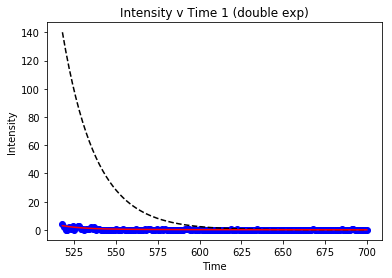

23.414
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 182
    # variables        = 4
    chi-square         = 3.26784610
    reduced chi-square = 0.01835869
    Akaike info crit   = -723.617360
    Bayesian info crit = -710.801333
[[Variables]]
    a1:    1.6726e-08 +/- 1.52743705 (9132024383.39%) (init = 70)
    a2:    3.11048228 +/- 1.27221810 (40.90%) (init = 70)
    tau1:  4.07802672 +/- 7.4412e+08 (18247058265.61%) (init = 20)
    tau2:  23.4146280 +/- 7.74972348 (33.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   = -0.922
    C(a1, a2)     =  0.882
    C(a2, tau1)   = -0.872
    C(a1, tau2)   = -0.839
    C(tau1, tau2) =  0.729
    C(a1, tau1)   = -0.618



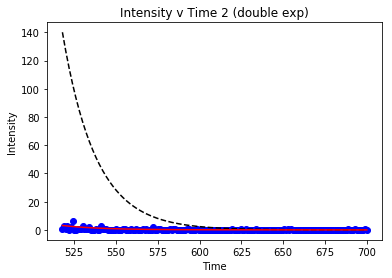

38.902
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 182
    # variables        = 4
    chi-square         = 1.60702674
    reduced chi-square = 0.00902824
    Akaike info crit   = -852.791015
    Bayesian info crit = -839.974989
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    0.90663991 (init = 70)
    a2:    2.07118267 (init = 70)
    tau1:  0.00337216 (init = 20)
    tau2:  38.9021321 (init = 20)



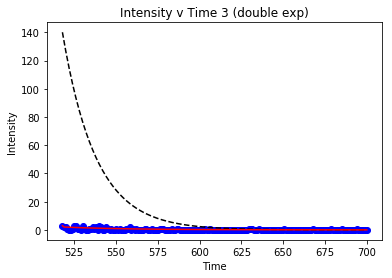

30.490
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 182
    # variables        = 4
    chi-square         = 2.70584832
    reduced chi-square = 0.01520140
    Akaike info crit   = -757.963601
    Bayesian info crit = -745.147574
[[Variables]]
    a1:    0.37826662 +/- 6.45873378 (1707.46%) (init = 70)
    a2:    2.61329457 +/- 6.32940524 (242.20%) (init = 70)
    tau1:  74.9999674 +/- 131.703136 (175.60%) (init = 20)
    tau2:  30.4901122 +/- 39.6707886 (130.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.999
    C(a2, tau1)   = -0.993
    C(a1, tau1)   =  0.992
    C(a1, tau2)   = -0.984
    C(a2, tau2)   =  0.979
    C(tau1, tau2) = -0.957



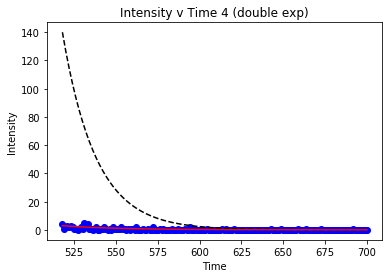

2.2244
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 182
    # variables        = 4
    chi-square         = 4.66079345
    reduced chi-square = 0.02618423
    Akaike info crit   = -658.997419
    Bayesian info crit = -646.181393
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    3.73794304 (init = 70)
    a2:    2.23987959 (init = 70)
    tau1:  37.7346366 (init = 20)
    tau2:  2.2244e-04 (init = 20)



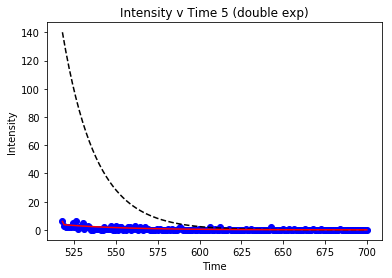

10.611
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 280
    # data points      = 182
    # variables        = 4
    chi-square         = 6.85445280
    reduced chi-square = 0.03850816
    Akaike info crit   = -588.797693
    Bayesian info crit = -575.981666
[[Variables]]
    a1:    3.30865437 +/- 1.33798419 (40.44%) (init = 70)
    a2:    3.0632e-10 +/- 0.03232053 (10551173343.57%) (init = 70)
    tau1:  57.8444965 +/- 19.2413000 (33.26%) (init = 20)
    tau2:  10.6114450 +/- 43255163.1 (407627453.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.939
    C(a1, a2)     =  0.901
    C(a1, tau2)   = -0.891
    C(a2, tau1)   = -0.871
    C(tau1, tau2) =  0.766
    C(a2, tau2)   = -0.671



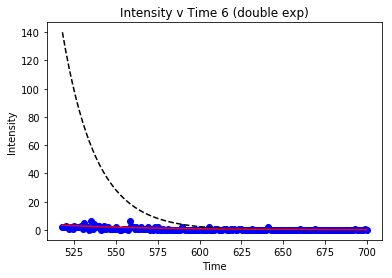

0.0190
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 182
    # variables        = 4
    chi-square         = 13.0586956
    reduced chi-square = 0.07336346
    Akaike info crit   = -471.488545
    Bayesian info crit = -458.672518
##  Warning: uncertainties could not be estimated:
    a2:    at boundary
[[Variables]]
    a1:    6.45326137 (init = 70)
    a2:    2.2928e-11 (init = 70)
    tau1:  41.3061265 (init = 20)
    tau2:  0.01902003 (init = 20)



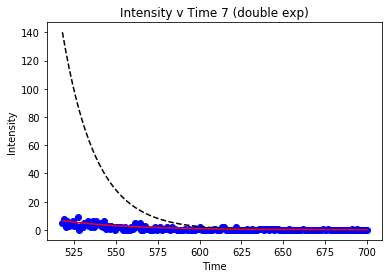

0.0300
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 182
    # variables        = 4
    chi-square         = 11.2044770
    reduced chi-square = 0.06294650
    Akaike info crit   = -499.360173
    Bayesian info crit = -486.544147
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    5.74787997 (init = 70)
    a2:    1.23800714 (init = 70)
    tau1:  53.0680453 (init = 20)
    tau2:  0.03000449 (init = 20)



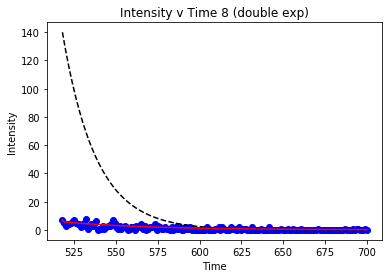

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 182
    # variables        = 4
    chi-square         = 31.9262286
    reduced chi-square = 0.17936084
    Akaike info crit   = -308.785342
    Bayesian info crit = -295.969315
[[Variables]]
    a1:    9.02731840 +/- 35.3233055 (391.29%) (init = 70)
    a2:    1.45368202 +/- 35.5248711 (2443.79%) (init = 70)
    tau1:  36.2836701 +/- 54.7662832 (150.94%) (init = 20)
    tau2:  74.9999392 +/- 54.8498893 (73.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -1.000
    C(a1, tau2)   =  0.995
    C(a2, tau2)   = -0.995
    C(a2, tau1)   = -0.993
    C(a1, tau1)   =  0.992
    C(tau1, tau2) =  0.977



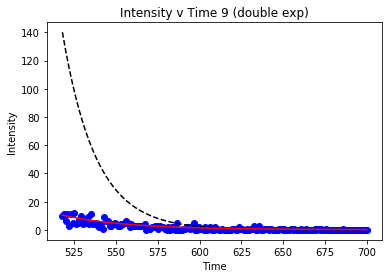

51.901
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 104
    # data points      = 182
    # variables        = 4
    chi-square         = 71.2448606
    reduced chi-square = 0.40025203
    Akaike info crit   = -162.694888
    Bayesian info crit = -149.878862
[[Variables]]
    a1:    6.82432849 +/- 1.29622374 (18.99%) (init = 70)
    a2:    10.3624489 +/- 0.92666794 (8.94%) (init = 70)
    tau1:  3.02285978 +/- 1.34271585 (44.42%) (init = 20)
    tau2:  51.9013094 +/- 7.32426295 (14.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   = -0.840
    C(a2, tau1)   = -0.688
    C(tau1, tau2) =  0.513
    C(a1, a2)     = -0.472
    C(a1, tau2)   =  0.432
    C(a1, tau1)   = -0.116



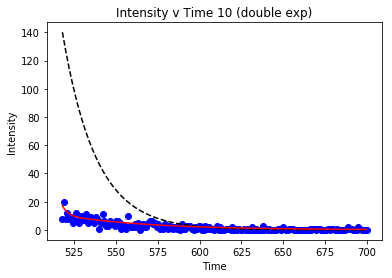

3.2320
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 182
    # variables        = 4
    chi-square         = 102.157535
    reduced chi-square = 0.57391873
    Akaike info crit   = -97.1032904
    Bayesian info crit = -84.2872636
[[Variables]]
    a1:    13.9168390 +/- 1.15083393 (8.27%) (init = 70)
    a2:    8.3830e-08 +/- 1.51536531 (1807674534.51%) (init = 70)
    tau1:  45.9583731 +/- 5.90909930 (12.86%) (init = 20)
    tau2:  3.23205795 +/- 1.2509e+08 (3870302949.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.865
    C(a1, tau2)   = -0.720
    C(a1, a2)     = -0.573
    C(tau1, tau2) =  0.549
    C(a2, tau1)   =  0.528



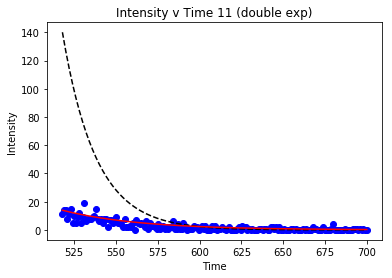

42.690
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 182
    # variables        = 4
    chi-square         = 152.871888
    reduced chi-square = 0.85883083
    Akaike info crit   = -23.7419738
    Bayesian info crit = -10.9259470
[[Variables]]
    a1:    0.60885467 +/- 1.49182766 (245.02%) (init = 70)
    a2:    18.6694475 +/- 1.05005563 (5.62%) (init = 70)
    tau1:  2.45807439 +/- 13.3310324 (542.34%) (init = 20)
    tau2:  42.6901511 +/- 4.07026108 (9.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   = -0.855
    C(a2, tau1)   = -0.706
    C(tau1, tau2) =  0.538
    C(a1, a2)     = -0.504
    C(a1, tau2)   =  0.461



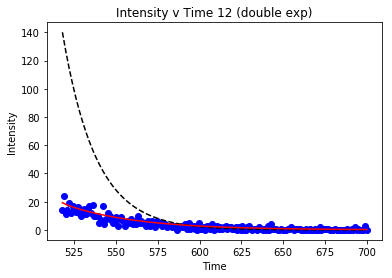

27.449
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 182
    # variables        = 4
    chi-square         = 494.348273
    reduced chi-square = 2.77723749
    Akaike info crit   = 189.860513
    Bayesian info crit = 202.676540
[[Variables]]
    a1:    4.15477051 +/- 32.9015356 (791.90%) (init = 70)
    a2:    27.0872808 +/- 32.5113979 (120.02%) (init = 70)
    tau1:  74.9999818 +/- 164.704449 (219.61%) (init = 20)
    tau2:  27.4495359 +/- 17.6689426 (64.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -1.000
    C(a2, tau1)   = -0.988
    C(a1, tau1)   =  0.987
    C(a1, tau2)   = -0.983
    C(a2, tau2)   =  0.980
    C(tau1, tau2) = -0.946



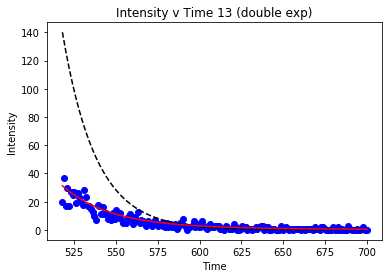

33.763
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 182
    # variables        = 4
    chi-square         = 756.704793
    reduced chi-square = 4.25115052
    Akaike info crit   = 267.343907
    Bayesian info crit = 280.159934
[[Variables]]
    a1:    28.8890845 +/- 33708833.4 (116683633.31%) (init = 70)
    a2:    8.97487928 +/- 33708788.7 (375590440.73%) (init = 70)
    tau1:  33.7501759 +/- 19544.4192 (57909.09%) (init = 20)
    tau2:  33.7636200 +/- 62752.5794 (185858.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -1.000
    C(a2, tau1)   =  0.986
    C(a1, tau1)   = -0.986
    C(a1, tau2)   = -0.986
    C(a2, tau2)   =  0.986
    C(tau1, tau2) =  0.943



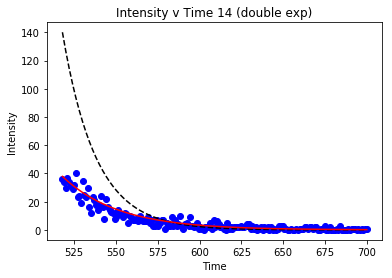

27.331
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 182
    # variables        = 4
    chi-square         = 989.300247
    reduced chi-square = 5.55786656
    Akaike info crit   = 316.124396
    Bayesian info crit = 328.940422
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    6.45777060 (init = 70)
    a2:    61.4736810 (init = 70)
    tau1:  0.02274890 (init = 20)
    tau2:  27.3310967 (init = 20)



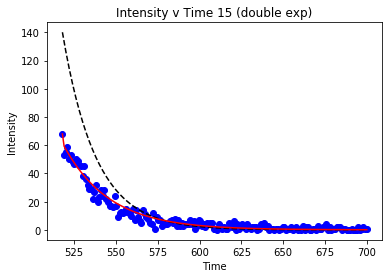

23.967
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 182
    # variables        = 4
    chi-square         = 5337.90748
    reduced chi-square = 29.9882443
    Akaike info crit   = 622.901981
    Bayesian info crit = 635.718007
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    19.3980183 (init = 70)
    a2:    77.5294011 (init = 70)
    tau1:  0.02847999 (init = 20)
    tau2:  23.9671940 (init = 20)



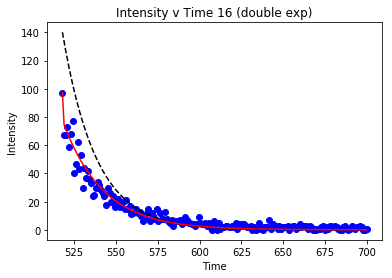

16.584
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 182
    # variables        = 4
    chi-square         = 11731.0413
    reduced chi-square = 65.9047265
    Akaike info crit   = 766.209638
    Bayesian info crit = 779.025665
[[Variables]]
    a1:    10.2710776 +/- 27.9296858 (271.93%) (init = 70)
    a2:    89.1112193 +/- 27.3690929 (30.71%) (init = 70)
    tau1:  74.9999792 +/- 194.757972 (259.68%) (init = 20)
    tau2:  16.5846503 +/- 4.05104589 (24.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.998
    C(a2, tau1)   =  0.965
    C(a1, tau2)   = -0.964
    C(a1, tau1)   = -0.962
    C(a2, tau2)   =  0.953
    C(tau1, tau2) =  0.874



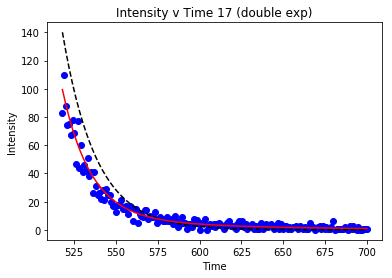

0.0359
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 182
    # variables        = 4
    chi-square         = 8291.07434
    reduced chi-square = 46.5790693
    Akaike info crit   = 703.044923
    Bayesian info crit = 715.860950
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    118.627773 (init = 70)
    a2:    24.2734370 (init = 70)
    tau1:  17.4901368 (init = 20)
    tau2:  0.03597050 (init = 20)



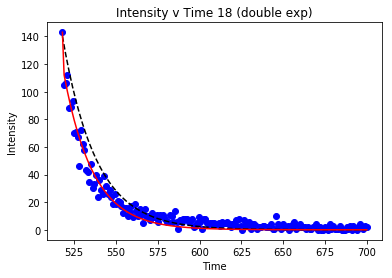

27.113
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 182
    # variables        = 4
    chi-square         = 4759.31495
    reduced chi-square = 26.7377244
    Akaike info crit   = 602.021124
    Bayesian info crit = 614.837151
[[Variables]]
    a1:    55.7891995 +/- 6.49414746 (11.64%) (init = 70)
    a2:    78.4737830 +/- 6.69297989 (8.53%) (init = 70)
    tau1:  4.51752250 +/- 0.57845276 (12.80%) (init = 20)
    tau2:  27.1137048 +/- 2.64673663 (9.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.989
    C(a2, tau2)   = -0.950
    C(a1, tau2)   =  0.948
    C(a2, tau1)   = -0.928
    C(a1, tau1)   =  0.886
    C(tau1, tau2) =  0.814



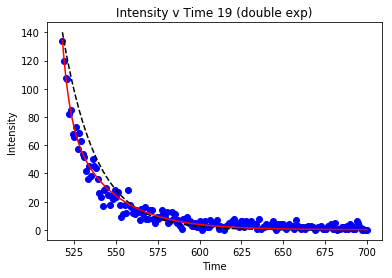

17.501
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 182
    # variables        = 4
    chi-square         = 7476.52912
    reduced chi-square = 42.0029726
    Akaike info crit   = 684.224140
    Bayesian info crit = 697.040167
[[Variables]]
    a1:    13.0259655 +/- 2.60147091 (19.97%) (init = 70)
    a2:    108.141477 +/- 2.12177606 (1.96%) (init = 70)
    tau1:  0.74031212 +/- 0.37941996 (51.25%) (init = 20)
    tau2:  17.5011815 +/- 0.69956832 (4.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   = -0.841
    C(a1, a2)     = -0.798
    C(a2, tau1)   = -0.707
    C(a1, tau2)   =  0.674
    C(tau1, tau2) =  0.539
    C(a1, tau1)   =  0.469



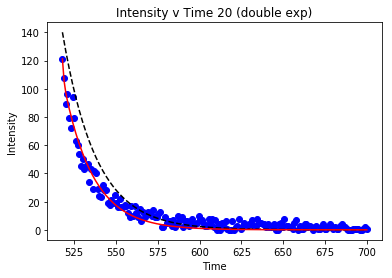

4.0803
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 182
    # variables        = 4
    chi-square         = 4831.15799
    reduced chi-square = 27.1413370
    Akaike info crit   = 604.747930
    Bayesian info crit = 617.563957
[[Variables]]
    a1:    75.8957180 +/- 7.05051421 (9.29%) (init = 70)
    a2:    40.4607203 +/- 6.83355203 (16.89%) (init = 70)
    tau1:  25.3241948 +/- 2.70968956 (10.70%) (init = 20)
    tau2:  4.08034014 +/- 0.79517656 (19.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.986
    C(a1, tau1)   = -0.950
    C(a2, tau1)   =  0.945
    C(a1, tau2)   = -0.926
    C(a2, tau2)   =  0.878
    C(tau1, tau2) =  0.814



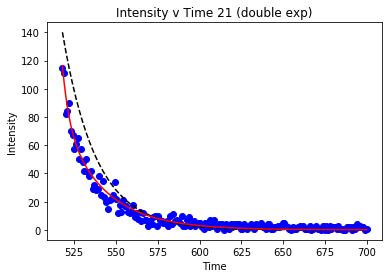

31.893
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 182
    # variables        = 4
    chi-square         = 5072.25608
    reduced chi-square = 28.4958207
    Akaike info crit   = 613.611242
    Bayesian info crit = 626.427269
[[Variables]]
    a1:    52.4300793 +/- 14.4516649 (27.56%) (init = 70)
    a2:    43.3366211 +/- 14.8402302 (34.24%) (init = 70)
    tau1:  6.58657580 +/- 1.65305226 (25.10%) (init = 20)
    tau2:  31.8931092 +/- 10.6082267 (33.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.996
    C(a1, tau2)   =  0.963
    C(a2, tau2)   = -0.961
    C(a2, tau1)   = -0.951
    C(a1, tau1)   =  0.930
    C(tau1, tau2) =  0.858



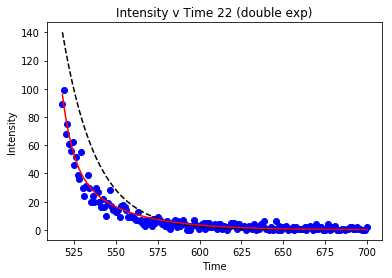

5.8836
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 182
    # variables        = 4
    chi-square         = 1457.11084
    reduced chi-square = 8.18601593
    Akaike info crit   = 386.597162
    Bayesian info crit = 399.413189
[[Variables]]
    a1:    30.8270672 +/- 5.40802414 (17.54%) (init = 70)
    a2:    55.5954344 +/- 5.22038149 (9.39%) (init = 70)
    tau1:  38.6537337 +/- 8.26607689 (21.38%) (init = 20)
    tau2:  5.88361866 +/- 0.64201886 (10.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.988
    C(a1, tau1)   = -0.938
    C(a2, tau1)   =  0.937
    C(a1, tau2)   = -0.923
    C(a2, tau2)   =  0.877
    C(tau1, tau2) =  0.793



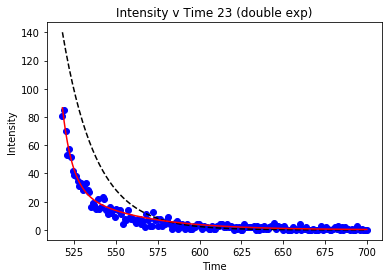

20.575
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 182
    # variables        = 4
    chi-square         = 314.946901
    reduced chi-square = 1.76936461
    Akaike info crit   = 107.808321
    Bayesian info crit = 120.624348
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a1:    3.42914043 (init = 70)
    a2:    44.5365854 (init = 70)
    tau1:  8.0822e-04 (init = 20)
    tau2:  20.5754291 (init = 20)



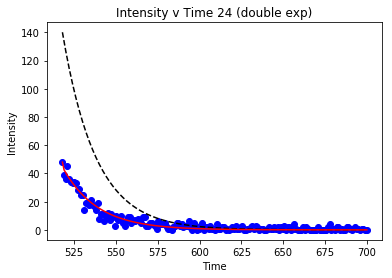

61.782
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 182
    # variables        = 4
    chi-square         = 164.783101
    reduced chi-square = 0.92574776
    Akaike info crit   = -10.0865449
    Bayesian info crit = 2.72948185
[[Variables]]
    a1:    22.7218637 +/- 4.98806304 (21.95%) (init = 70)
    a2:    8.28702126 +/- 5.16229452 (62.29%) (init = 70)
    tau1:  13.3850694 +/- 2.83970860 (21.22%) (init = 20)
    tau2:  61.7829575 +/- 32.8031631 (53.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.994
    C(a1, tau2)   =  0.952
    C(a2, tau2)   = -0.950
    C(a2, tau1)   = -0.945
    C(a1, tau1)   =  0.918
    C(tau1, tau2) =  0.835



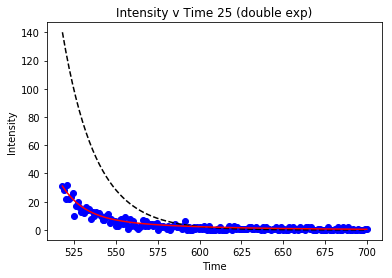

3.5859
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 182
    # variables        = 4
    chi-square         = 81.4583067
    reduced chi-square = 0.45763094
    Akaike info crit   = -138.312598
    Bayesian info crit = -125.496571
[[Variables]]
    a1:    15.8316213 +/- 1.51135961 (9.55%) (init = 70)
    a2:    2.90785713 +/- 1.52426488 (52.42%) (init = 70)
    tau1:  35.0909188 +/- 4.46308134 (12.72%) (init = 20)
    tau2:  3.58591393 +/- 3.69660487 (103.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.901
    C(a1, tau2)   = -0.822
    C(a1, a2)     = -0.810
    C(a2, tau1)   =  0.763
    C(tau1, tau2) =  0.661
    C(a2, tau2)   =  0.446



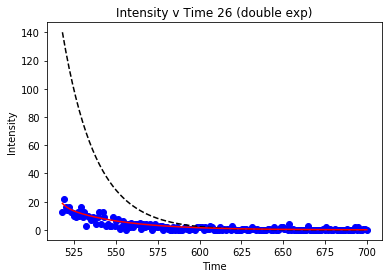

52.396
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 182
    # variables        = 4
    chi-square         = 93.3964783
    reduced chi-square = 0.52469932
    Akaike info crit   = -113.421855
    Bayesian info crit = -100.605828
[[Variables]]
    a1:    16.0871990 +/- 2.51001584 (15.60%) (init = 70)
    a2:    7.09114055 +/- 2.69336353 (37.98%) (init = 70)
    tau1:  7.92100270 +/- 1.85964658 (23.48%) (init = 20)
    tau2:  52.3965351 +/- 20.7023569 (39.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.962
    C(a2, tau2)   = -0.916
    C(a1, tau2)   =  0.902
    C(a2, tau1)   = -0.895
    C(a1, tau1)   =  0.779
    C(tau1, tau2) =  0.737



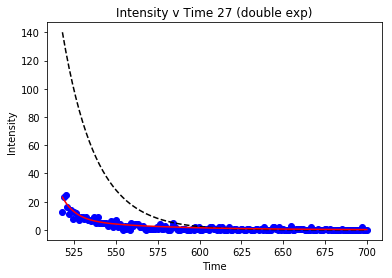

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 144
    # data points      = 182
    # variables        = 4
    chi-square         = 19.9015457
    reduced chi-square = 0.11180644
    Akaike info crit   = -394.804090
    Bayesian info crit = -381.988063
[[Variables]]
    a1:    10.1364473 +/- 6.84304392 (67.51%) (init = 70)
    a2:    1.86276030 +/- 6.99146078 (375.33%) (init = 70)
    tau1:  24.9512139 +/- 11.0812935 (44.41%) (init = 20)
    tau2:  74.9999997 +/- 21.3525488 (28.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.999
    C(a1, tau2)   = -0.984
    C(a2, tau2)   =  0.983
    C(a2, tau1)   = -0.976
    C(a1, tau1)   =  0.968
    C(tau1, tau2) = -0.930



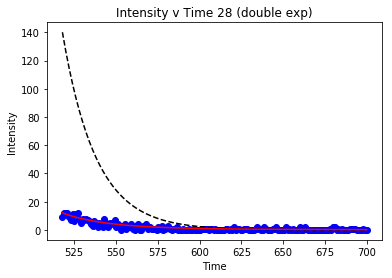

2.4181
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 182
    # variables        = 4
    chi-square         = 21.4498183
    reduced chi-square = 0.12050460
    Akaike info crit   = -381.168873
    Bayesian info crit = -368.352847
[[Variables]]
    a1:    8.40169942 +/- 0.79914131 (9.51%) (init = 70)
    a2:    2.92882012 +/- 0.97695277 (33.36%) (init = 70)
    tau1:  33.7245194 +/- 4.62697589 (13.72%) (init = 20)
    tau2:  2.41813235 +/- 1.71067556 (70.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.855
    C(a1, tau2)   = -0.703
    C(a1, a2)     = -0.682
    C(a2, tau1)   =  0.605
    C(tau1, tau2) =  0.536
    C(a2, tau2)   =  0.163



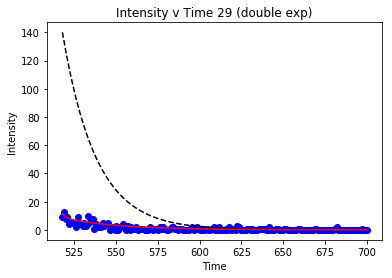

2.3320
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 182
    # variables        = 4
    chi-square         = 13.2525473
    reduced chi-square = 0.07445251
    Akaike info crit   = -468.806677
    Bayesian info crit = -455.990650
[[Variables]]
    a1:    7.99416332 +/- 0.72486578 (9.07%) (init = 70)
    a2:    1.2846e-08 +/- 0.94548398 (7360285646.77%) (init = 70)
    tau1:  30.2911784 +/- 3.62055914 (11.95%) (init = 20)
    tau2:  2.33200384 +/- 3.3433e+08 (14336523089.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1)   = -0.851
    C(a1, tau2)   = -0.763
    C(a1, a2)     = -0.655
    C(tau1, tau2) =  0.578
    C(a2, tau1)   =  0.578
    C(a2, tau2)   =  0.238



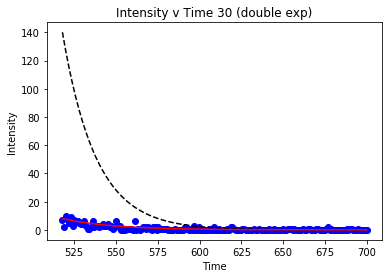

41.559
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 182
    # variables        = 4
    chi-square         = 11.2669774
    reduced chi-square = 0.06329763
    Akaike info crit   = -498.347769
    Bayesian info crit = -485.531742
[[Variables]]
    a1:    3.3452e-07 +/- 3.04925874 (911533060.41%) (init = 70)
    a2:    6.79219405 +/- 3.21523628 (47.34%) (init = 70)
    tau1:  11.3590821 +/- 99104470.4 (872469003.33%) (init = 20)
    tau2:  41.5599578 +/- 12.4375502 (29.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.988
    C(a2, tau2)   = -0.962
    C(a1, tau2)   =  0.961
    C(a2, tau1)   = -0.945
    C(a1, tau1)   =  0.900
    C(tau1, tau2) =  0.852



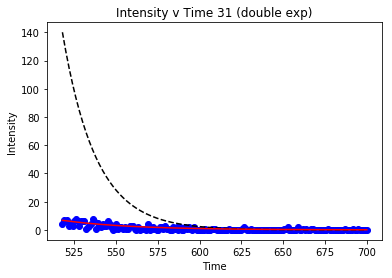

43.095
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 182
    # variables        = 4
    chi-square         = 19.1041958
    reduced chi-square = 0.10732694
    Akaike info crit   = -402.245963
    Bayesian info crit = -389.429936
[[Variables]]
    a1:    2.5176e-08 +/- 15.2859270 (60716856638.40%) (init = 70)
    a2:    6.76139960 +/- 508.422464 (7519.49%) (init = 70)
    tau1:  56.9748961 +/- 1.4364e+08 (252118370.05%) (init = 20)
    tau2:  43.0954925 +/- 464.249931 (1077.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     =  1.000
    C(a2, tau1)   =  0.999
    C(a1, tau1)   =  0.999
    C(a1, tau2)   =  0.999
    C(a2, tau2)   =  0.999
    C(tau1, tau2) =  0.996



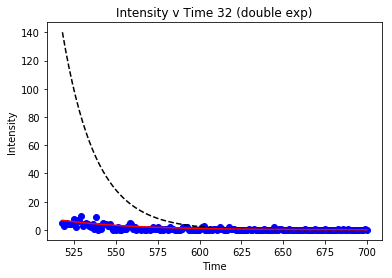

32.877
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 182
    # variables        = 4
    chi-square         = 7.61566861
    reduced chi-square = 0.04278466
    Akaike info crit   = -569.631400
    Bayesian info crit = -556.815374
[[Variables]]
    a1:    1.1581e-07 +/- 0.83458959 (720624889.36%) (init = 70)
    a2:    5.92513325 +/- 0.30564841 (5.16%) (init = 70)
    tau1:  0.18379547 +/- 57558520.5 (31316615950.67%) (init = 20)
    tau2:  32.8770872 +/- 3.17556792 (9.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   = -0.720
    C(a1, a2)     = -0.366
    C(a2, tau1)   = -0.342
    C(a1, tau2)   =  0.264
    C(tau1, tau2) =  0.237
    C(a1, tau1)   =  0.122



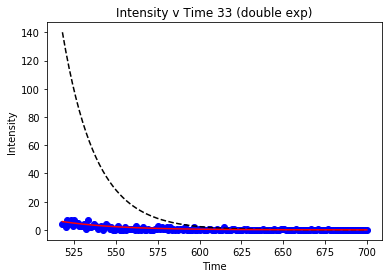

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 182
    # variables        = 4
    chi-square         = 9.14369235
    reduced chi-square = 0.05136906
    Akaike info crit   = -536.351518
    Bayesian info crit = -523.535491
[[Variables]]
    a1:    5.59678806 +/- 4.99000242 (89.16%) (init = 70)
    a2:    0.82347315 +/- 5.15248037 (625.70%) (init = 70)
    tau1:  24.1361169 +/- 15.6833545 (64.98%) (init = 20)
    tau2:  74.9999930 +/- 28.8773145 (38.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.998
    C(a1, tau2)   = -0.984
    C(a2, tau2)   =  0.983
    C(a2, tau1)   = -0.969
    C(a1, tau1)   =  0.955
    C(tau1, tau2) = -0.921



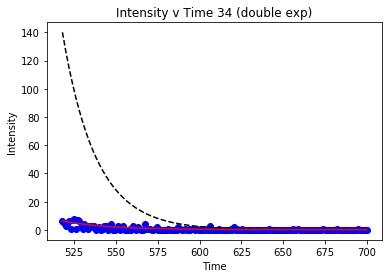

26.546
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 182
    # variables        = 4
    chi-square         = 9.57157709
    reduced chi-square = 0.05377291
    Akaike info crit   = -528.027983
    Bayesian info crit = -515.211957
[[Variables]]
    a1:    0.89204016 +/- 7.15411295 (801.99%) (init = 70)
    a2:    4.31397711 +/- 6.96003226 (161.34%) (init = 70)
    tau1:  74.9999532 +/- 310.514405 (414.02%) (init = 20)
    tau2:  26.5468722 +/- 27.9412425 (105.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.998
    C(a2, tau1)   =  0.988
    C(a1, tau1)   = -0.987
    C(a1, tau2)   = -0.976
    C(a2, tau2)   =  0.965
    C(tau1, tau2) =  0.938



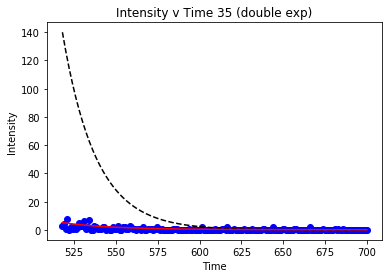

40.037
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 182
    # variables        = 4
    chi-square         = 3.65004632
    reduced chi-square = 0.02050588
    Akaike info crit   = -703.486563
    Bayesian info crit = -690.670536
[[Variables]]
    a1:    6.3413e-08 +/- 2.04990970 (3232609374.11%) (init = 70)
    a2:    3.50657360 +/- 3.75367817 (107.05%) (init = 70)
    tau1:  14.1260425 +/- 1.8295e+08 (1295132551.45%) (init = 20)
    tau2:  40.0376253 +/- 21.0457347 (52.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     =  0.996
    C(a1, tau2)   = -0.975
    C(a2, tau2)   = -0.973
    C(a2, tau1)   = -0.957
    C(a1, tau1)   = -0.936
    C(tau1, tau2) =  0.884



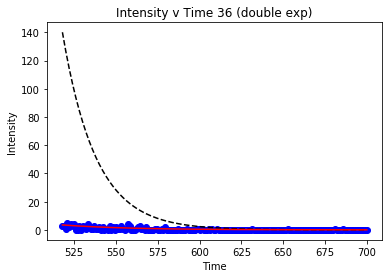

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 182
    # variables        = 4
    chi-square         = 2.65588871
    reduced chi-square = 0.01492072
    Akaike info crit   = -761.355379
    Bayesian info crit = -748.539352
[[Variables]]
    a1:    5.44838273 +/- 0.48539708 (8.91%) (init = 70)
    a2:    0.96408679 +/- 0.48427704 (50.23%) (init = 70)
    tau1:  8.58085956 +/- 1.46640750 (17.09%) (init = 20)
    tau2:  74.9999520 +/- 46.3917079 (61.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   =  0.903
    C(a1, a2)     = -0.853
    C(a2, tau1)   = -0.815
    C(a1, tau2)   = -0.791
    C(tau1, tau2) = -0.673
    C(a1, tau1)   =  0.502



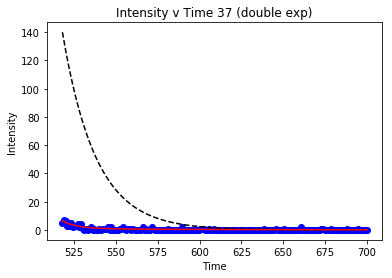

74.999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 182
    # variables        = 4
    chi-square         = 2.39269923
    reduced chi-square = 0.01344213
    Akaike info crit   = -780.348393
    Bayesian info crit = -767.532366
[[Variables]]
    a1:    4.10286627 +/- 0.55721159 (13.58%) (init = 70)
    a2:    0.88292615 +/- 0.56673212 (64.19%) (init = 70)
    tau1:  10.0530083 +/- 2.38271878 (23.70%) (init = 20)
    tau2:  74.9995176 +/- 60.1721958 (80.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, tau2)   =  0.923
    C(a1, a2)     = -0.892
    C(a2, tau1)   = -0.853
    C(a1, tau2)   = -0.841
    C(tau1, tau2) = -0.727
    C(a1, tau1)   =  0.618



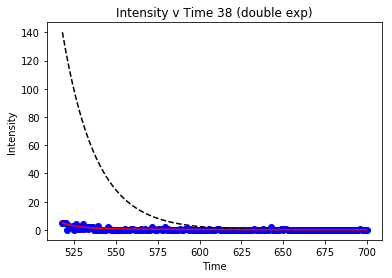

0.0022
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 107
    # data points      = 182
    # variables        = 4
    chi-square         = 2.78124847
    reduced chi-square = 0.01562499
    Akaike info crit   = -752.961432
    Bayesian info crit = -740.145406
##  Warning: uncertainties could not be estimated:
    a2:    at boundary
[[Variables]]
    a1:    4.34408897 (init = 70)
    a2:    3.3903e-10 (init = 70)
    tau1:  13.7528864 (init = 20)
    tau2:  0.00220786 (init = 20)



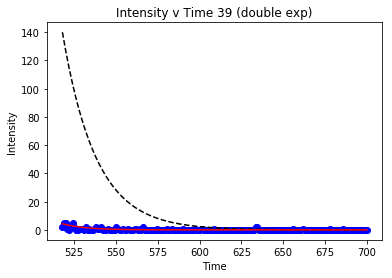

21.795
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 182
    # variables        = 4
    chi-square         = 4.41349880
    reduced chi-square = 0.02479494
    Akaike info crit   = -668.919686
    Bayesian info crit = -656.103659
[[Variables]]
    a1:    0.42720341 +/- 2.96877362 (694.93%) (init = 70)
    a2:    3.70050062 +/- 2.81987305 (76.20%) (init = 70)
    tau1:  74.9998238 +/- 315.819089 (421.09%) (init = 20)
    tau2:  21.7953506 +/- 14.6190350 (67.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)     = -0.994
    C(a2, tau1)   =  0.979
    C(a1, tau1)   = -0.979
    C(a1, tau2)   = -0.957
    C(a2, tau2)   =  0.928
    C(tau1, tau2) =  0.900



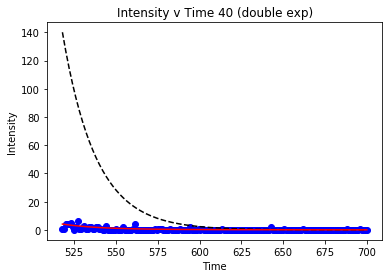

In [13]:
tau1TimeDoubleExp = []
a1TimeDoubleExp = []
tau2TimeDoubleExp = []
a2TimeDoubleExp = []
for i in range(1, 41, 1):
    x = xstuff #store the x data
    y = globals()["point" + str(i)] #store the y data

    def func(x, a1, a2, tau1, tau2):
            return globals()["background" + str(i)] + a1*np.exp(-(x-518)/tau1) + a2*np.exp(-(x-518)/tau2)

    weight = [.033*n for n in y] + globals()["background" + str(i) + "std"]
    gmodel = Model(func)
    pars = Parameters()
    pars.add('a1', value = 70, min = 0, max = 120)
    pars.add('a2', value = 70, min = 0, max = 120)
    pars.add('tau1', value = 20, min = 0, max = 75)
    pars.add('tau2', value = 20, min = 0, max = 75)
    result = gmodel.fit(y, pars, x=x, weights = weight)
    results = result.fit_report()
    tau1 = ""
    a1 = ""
    tau2 = ""
    a2 = ""
    for n in range(6):
        tau1 += str(results[results.find('tau1') + n + 7])
    tau1TimeDoubleExp.append(float(tau1))
    for n in range(6):
        a1 += str(results[results.find('a1') + n + 7])
    a1TimeDoubleExp.append(float(a1))
    for n in range(6):
        tau2 += str(results[results.find('tau2') + n + 7])
    print(tau2)
    tau2TimeDoubleExp.append(float(tau2))
    for n in range(6):
        a2 += str(results[results.find('a2') + n + 7])
    if a2 != "at bou":
        a2TimeDoubleExp.append(float(a2))

    print(result.fit_report())
    plt.title("Intensity v Time " + str(i) + " (double exp)")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.plot(x, y, 'bo')
    plt.plot(x, result.init_fit, 'k--')
    plt.plot(x, result.best_fit, 'r-')
    plt.show()


[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 182
    # variables        = 2
    chi-square         = 21.1068852
    reduced chi-square = 0.11726047
    Akaike info crit   = -388.102145
    Bayesian info crit = -381.694131
[[Variables]]
    a1:    20.0000000 +/- 1.27405471 (6.37%) (init = 70)
    tau1:  0.43395696 +/- 0.16135351 (37.18%) (init = 20)



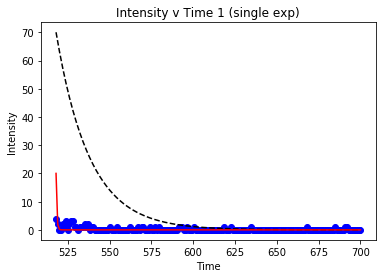

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 182
    # variables        = 2
    chi-square         = 16.9377537
    reduced chi-square = 0.09409863
    Akaike info crit   = -428.152013
    Bayesian info crit = -421.744000
[[Variables]]
    a1:    20.0000001 +/- 1.83190992 (9.16%) (init = 70)
    tau1:  0.55869148 +/- 0.12278992 (21.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.224



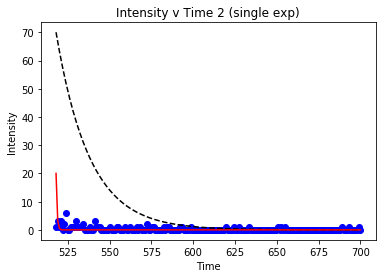

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 182
    # variables        = 2
    chi-square         = 19.5897880
    reduced chi-square = 0.10883216
    Akaike info crit   = -401.677687
    Bayesian info crit = -395.269673
[[Variables]]
    a1:    20.0000000 +/- 9.22934690 (46.15%) (init = 70)
    tau1:  0.47556717 +/- 0.14975371 (31.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.103



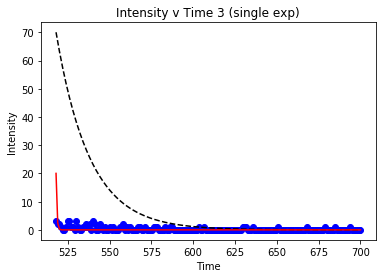

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 182
    # variables        = 2
    chi-square         = 25.4526034
    reduced chi-square = 0.14140335
    Akaike info crit   = -354.028335
    Bayesian info crit = -347.620322
[[Variables]]
    a1:    20.0000000 +/- 0.30964608 (1.55%) (init = 70)
    tau1:  0.38808675 +/- 0.22088203 (56.92%) (init = 20)



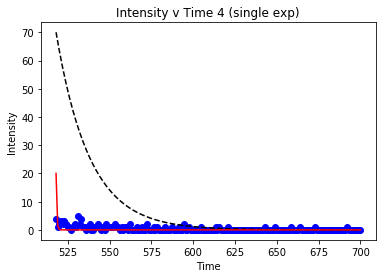

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 182
    # variables        = 2
    chi-square         = 36.3420412
    reduced chi-square = 0.20190023
    Akaike info crit   = -289.207725
    Bayesian info crit = -282.799712
##  Warning: uncertainties could not be estimated:
    a1:    at boundary
[[Variables]]
    a1:    20.0000000 (init = 70)
    tau1:  0.57734809 (init = 20)



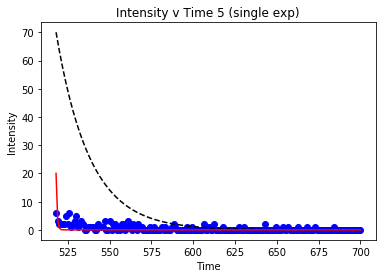

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 182
    # variables        = 2
    chi-square         = 31.6735569
    reduced chi-square = 0.17596421
    Akaike info crit   = -314.231463
    Bayesian info crit = -307.823449
[[Variables]]
    a1:    20.0000000 +/- 2.09104052 (10.46%) (init = 70)
    tau1:  0.55258910 +/- 0.18532398 (33.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.160



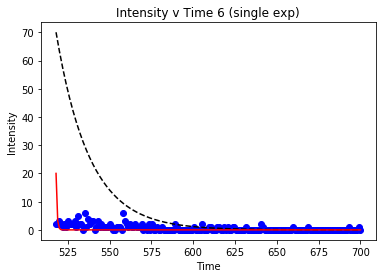

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 490
    # data points      = 182
    # variables        = 2
    chi-square         = 76.5729870
    reduced chi-square = 0.42540548
    Akaike info crit   = -153.568743
    Bayesian info crit = -147.160729
[[Variables]]
    a1:    20.0000001 +/- 1.51416633 (7.57%) (init = 70)
    tau1:  2.92203339 +/- 0.48419418 (16.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.589



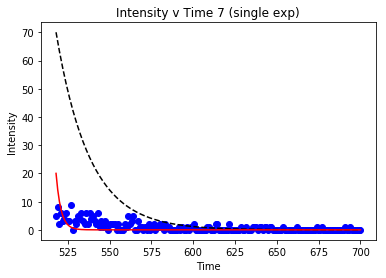

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 182
    # variables        = 2
    chi-square         = 81.1922309
    reduced chi-square = 0.45106795
    Akaike info crit   = -142.908056
    Bayesian info crit = -136.500043
[[Variables]]
    a1:    20.0000001 +/- 1.27891800 (6.39%) (init = 70)
    tau1:  4.07360688 +/- 0.55774349 (13.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.537



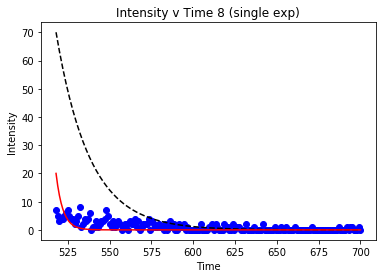

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 182
    # variables        = 2
    chi-square         = 118.408267
    reduced chi-square = 0.65782371
    Akaike info crit   = -74.2360018
    Bayesian info crit = -67.8279884
[[Variables]]
    a1:    20.0000000 +/- 0.98744244 (4.94%) (init = 70)
    tau1:  13.7067989 +/- 1.22850013 (8.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.658



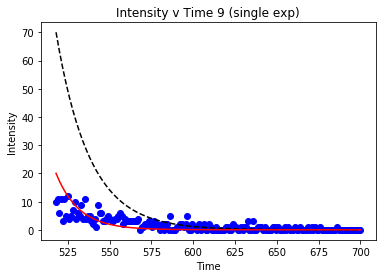

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 182
    # variables        = 2
    chi-square         = 134.869801
    reduced chi-square = 0.74927667
    Akaike info crit   = -50.5448203
    Bayesian info crit = -44.1368069
[[Variables]]
    a1:    20.0000000 +/- 0.81425880 (4.07%) (init = 70)
    tau1:  17.9201099 +/- 1.44117326 (8.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.644



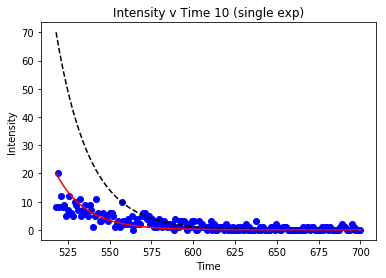

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 182
    # variables        = 2
    chi-square         = 171.286176
    reduced chi-square = 0.95158987
    Akaike info crit   = -7.04211904
    Bayesian info crit = -0.63410567
[[Variables]]
    a1:    20.0000000 +/- 1.12063255 (5.60%) (init = 70)
    tau1:  25.9017595 +/- 2.06892286 (7.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.692



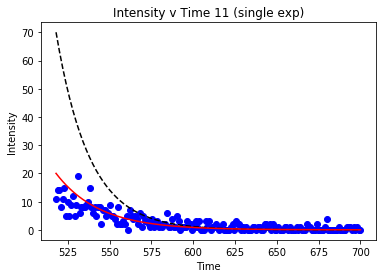

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 182
    # variables        = 2
    chi-square         = 157.043500
    reduced chi-square = 0.87246389
    Akaike info crit   = -22.8420609
    Bayesian info crit = -16.4340475
[[Variables]]
    a1:    20.0000000 +/- 0.19009031 (0.95%) (init = 70)
    tau1:  38.1433543 +/- 2.38373919 (6.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.685



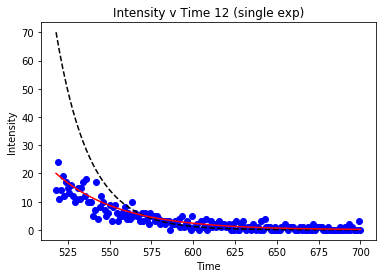

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 182
    # variables        = 2
    chi-square         = 495.801342
    reduced chi-square = 2.75445190
    Akaike info crit   = 186.394692
    Bayesian info crit = 192.802706
[[Variables]]
    a1:    31.0181891 +/- 0.70459946 (2.27%) (init = 70)
    tau1:  31.3840279 +/- 1.84022747 (5.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.690



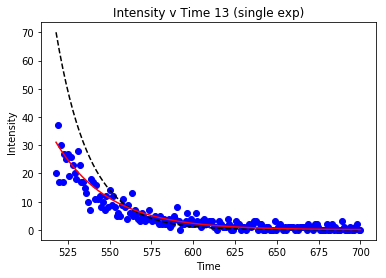

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 182
    # variables        = 2
    chi-square         = 756.704791
    reduced chi-square = 4.20391551
    Akaike info crit   = 263.343906
    Bayesian info crit = 269.751920
[[Variables]]
    a1:    37.8639005 +/- 0.68402772 (1.81%) (init = 70)
    tau1:  33.7535982 +/- 1.69396008 (5.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.687



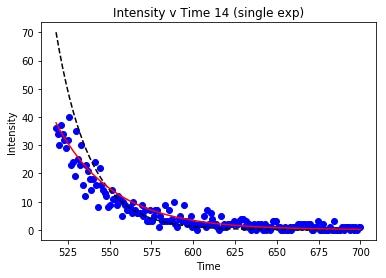

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 182
    # variables        = 2
    chi-square         = 1156.13179
    reduced chi-square = 6.42295440
    Akaike info crit   = 340.486762
    Bayesian info crit = 346.894775
[[Variables]]
    a1:    63.3778637 +/- 0.58539318 (0.92%) (init = 70)
    tau1:  25.7713699 +/- 0.67182399 (2.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.681



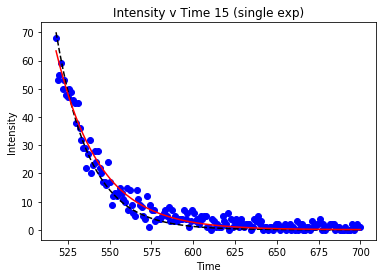

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 182
    # variables        = 2
    chi-square         = 7873.61854
    reduced chi-square = 43.7423252
    Akaike info crit   = 689.642473
    Bayesian info crit = 696.050487
[[Variables]]
    a1:    85.3341719 +/- 1.27050913 (1.49%) (init = 70)
    tau1:  19.9858520 +/- 0.82690096 (4.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.642



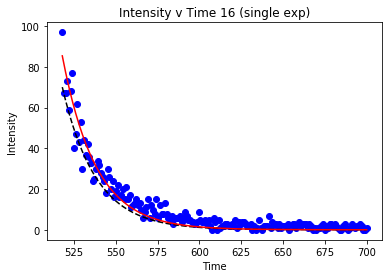

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 182
    # variables        = 2
    chi-square         = 11837.1028
    reduced chi-square = 65.7616822
    Akaike info crit   = 763.847724
    Bayesian info crit = 770.255738
[[Variables]]
    a1:    98.7019440 +/- 1.41751474 (1.44%) (init = 70)
    tau1:  19.0017774 +/- 0.78401902 (4.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.664



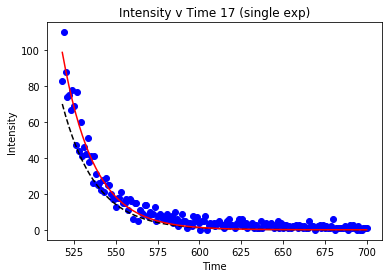

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 182
    # variables        = 2
    chi-square         = 20698.1200
    reduced chi-square = 114.989556
    Akaike info crit   = 865.550047
    Bayesian info crit = 871.958061
[[Variables]]
    a1:    120.000000 +/- 3.32202620 (2.77%) (init = 70)
    tau1:  17.0996439 +/- 0.64563107 (3.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.631



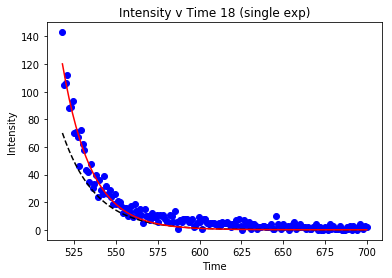

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 182
    # variables        = 2
    chi-square         = 12082.7457
    reduced chi-square = 67.1263652
    Akaike info crit   = 767.585924
    Bayesian info crit = 773.993937
[[Variables]]
    a1:    120.000000 +/- 0.24516397 (0.20%) (init = 70)
    tau1:  15.9838099 +/- 0.46069989 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.617



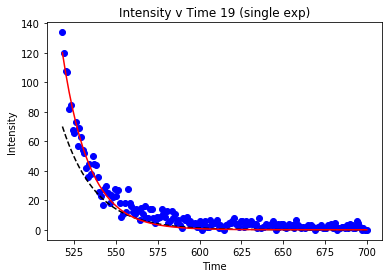

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 182
    # variables        = 2
    chi-square         = 8771.84994
    reduced chi-square = 48.7324996
    Akaike info crit   = 709.303929
    Bayesian info crit = 715.711943
[[Variables]]
    a1:    114.778607 +/- 1.10143731 (0.96%) (init = 70)
    tau1:  15.6640169 +/- 0.43350671 (2.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.638



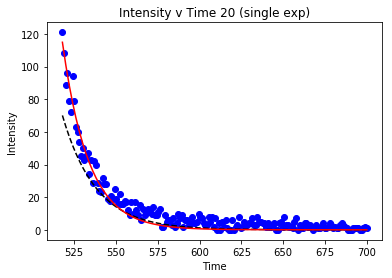

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
    # variables        = 2
    chi-square         = 7478.64839
    reduced chi-square = 41.5480466
    Akaike info crit   = 680.275722
    Bayesian info crit = 686.683736
[[Variables]]
    a1:    110.104964 +/- 1.05554191 (0.96%) (init = 70)
    tau1:  15.1881114 +/- 0.41198433 (2.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.622



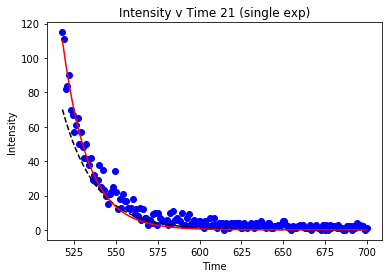

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
    # variables        = 2
    chi-square         = 5950.96198
    reduced chi-square = 33.0608999
    Akaike info crit   = 638.688869
    Bayesian info crit = 645.096882
[[Variables]]
    a1:    92.3144799 +/- 1.16505250 (1.26%) (init = 70)
    tau1:  13.9626246 +/- 0.50957329 (3.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.623



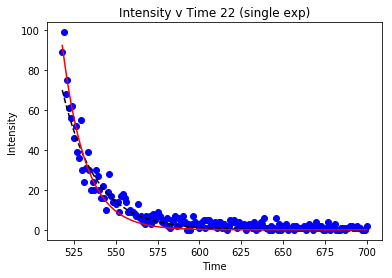

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
    # variables        = 2
    chi-square         = 2380.69299
    reduced chi-square = 13.2260722
    Akaike info crit   = 471.947518
    Bayesian info crit = 478.355531
[[Variables]]
    a1:    82.8057217 +/- 0.85367435 (1.03%) (init = 70)
    tau1:  11.8657168 +/- 0.35141924 (2.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.606



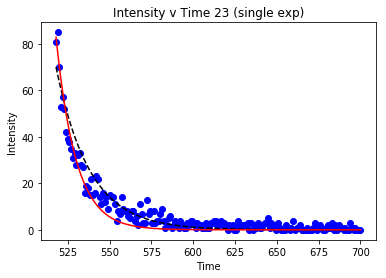

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 182
    # variables        = 2
    chi-square         = 337.443231
    reduced chi-square = 1.87468462
    Akaike info crit   = 116.365090
    Bayesian info crit = 122.773103
[[Variables]]
    a1:    45.7515981 +/- 0.47417436 (1.04%) (init = 70)
    tau1:  19.5507542 +/- 0.56402234 (2.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.664



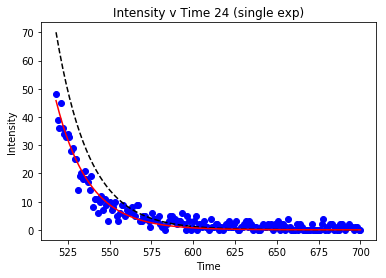

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 182
    # variables        = 2
    chi-square         = 178.395017
    reduced chi-square = 0.99108343
    Akaike info crit   = 0.35883492
    Bayesian info crit = 6.76684830
[[Variables]]
    a1:    30.1701690 +/- 0.48111950 (1.59%) (init = 70)
    tau1:  20.4627561 +/- 0.85600835 (4.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.640



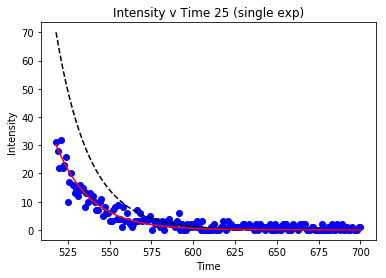

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 182
    # variables        = 2
    chi-square         = 97.1172725
    reduced chi-square = 0.53954040
    Akaike info crit   = -110.311915
    Bayesian info crit = -103.903901
[[Variables]]
    a1:    20.0000000 +/- 0.42941618 (2.15%) (init = 70)
    tau1:  24.3706917 +/- 1.42029667 (5.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.645



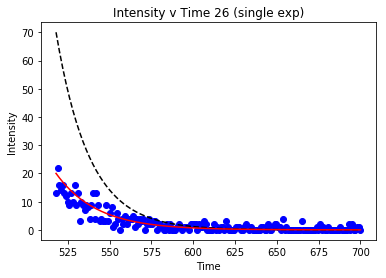

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 182
    # variables        = 2
    chi-square         = 104.782352
    reduced chi-square = 0.58212418
    Akaike info crit   = -96.4860821
    Bayesian info crit = -90.0780687
[[Variables]]
    a1:    21.7601027 +/- 0.56579700 (2.60%) (init = 70)
    tau1:  15.5915953 +/- 0.99748819 (6.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.634



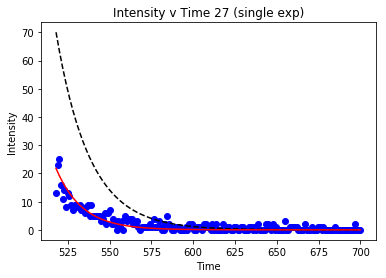

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 182
    # variables        = 2
    chi-square         = 84.0963775
    reduced chi-square = 0.46720210
    Akaike info crit   = -136.511861
    Bayesian info crit = -130.103848
[[Variables]]
    a1:    20.0000000 +/- 0.86683751 (4.33%) (init = 70)
    tau1:  12.1835081 +/- 0.94243060 (7.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.684



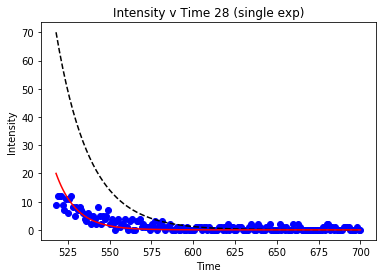

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 182
    # variables        = 2
    chi-square         = 86.1767570
    reduced chi-square = 0.47875976
    Akaike info crit   = -132.064326
    Bayesian info crit = -125.656312
[[Variables]]
    a1:    20.0000000 +/- 0.69379423 (3.47%) (init = 70)
    tau1:  7.68198099 +/- 0.77147942 (10.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.597



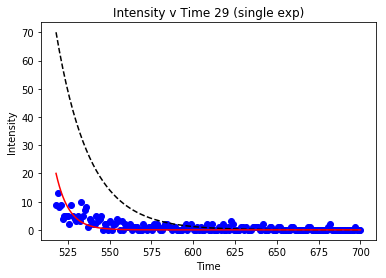

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 182
    # variables        = 2
    chi-square         = 63.2401922
    reduced chi-square = 0.35133440
    Akaike info crit   = -188.386128
    Bayesian info crit = -181.978114
[[Variables]]
    a1:    20.0000000 +/- 0.65581743 (3.28%) (init = 70)
    tau1:  5.36000335 +/- 0.56706543 (10.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.674



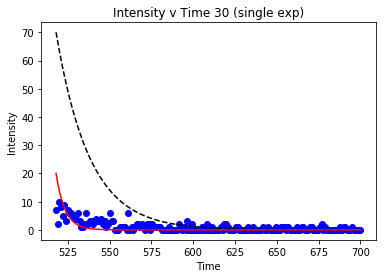

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 182
    # variables        = 2
    chi-square         = 80.7866230
    reduced chi-square = 0.44881457
    Akaike info crit   = -143.819543
    Bayesian info crit = -137.411530
[[Variables]]
    a1:    20.0000000 +/- 1.23032841 (6.15%) (init = 70)
    tau1:  5.72760763 +/- 0.70789107 (12.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.662



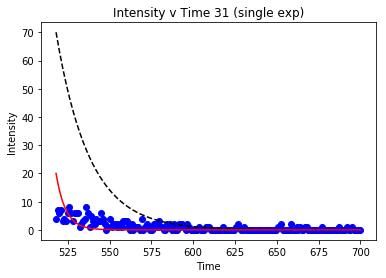

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 182
    # variables        = 2
    chi-square         = 86.3238018
    reduced chi-square = 0.47957668
    Akaike info crit   = -131.754041
    Bayesian info crit = -125.346028
[[Variables]]
    a1:    20.0000000 +/- 1.60147195 (8.01%) (init = 70)
    tau1:  7.71852895 +/- 0.88599518 (11.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.687



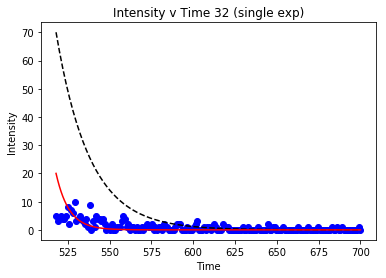

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 182
    # variables        = 2
    chi-square         = 51.8491660
    reduced chi-square = 0.28805092
    Akaike info crit   = -224.531546
    Bayesian info crit = -218.123533
[[Variables]]
    a1:    20.0000000 +/- 0.99855648 (4.99%) (init = 70)
    tau1:  4.03197897 +/- 0.47518567 (11.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.644



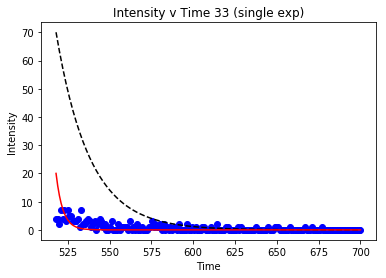

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 182
    # variables        = 2
    chi-square         = 57.3857030
    reduced chi-square = 0.31880946
    Akaike info crit   = -206.066491
    Bayesian info crit = -199.658478
[[Variables]]
    a1:    20.0000000 +/- 1.39516619 (6.98%) (init = 70)
    tau1:  4.38848080 +/- 0.50385214 (11.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.581



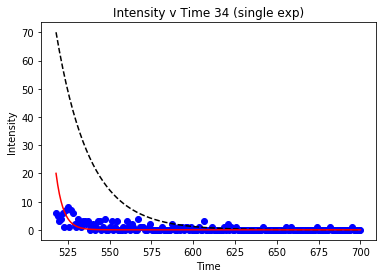

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 182
    # variables        = 2
    chi-square         = 42.1415902
    reduced chi-square = 0.23411995
    Akaike info crit   = -262.260821
    Bayesian info crit = -255.852808
[[Variables]]
    a1:    20.0000000 +/- 1.16583710 (5.83%) (init = 70)
    tau1:  1.85748281 +/- 0.30478574 (16.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.535



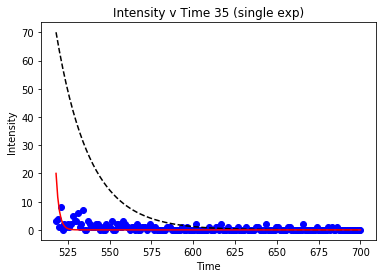

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 182
    # variables        = 2
    chi-square         = 28.5809234
    reduced chi-square = 0.15878291
    Akaike info crit   = -332.930632
    Bayesian info crit = -326.522618
[[Variables]]
    a1:    20.0000000 +/- 1.70653712 (8.53%) (init = 70)
    tau1:  0.63618511 +/- 0.16136176 (25.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) = -0.201



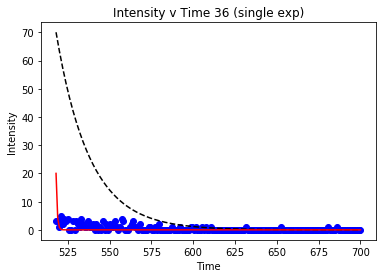

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 182
    # variables        = 2
    chi-square         = 28.8737518
    reduced chi-square = 0.16040973
    Akaike info crit   = -331.075422
    Bayesian info crit = -324.667408
[[Variables]]
    a1:    20.0000000 +/- 0.58723290 (2.94%) (init = 70)
    tau1:  1.39415934 +/- 0.17279441 (12.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.506



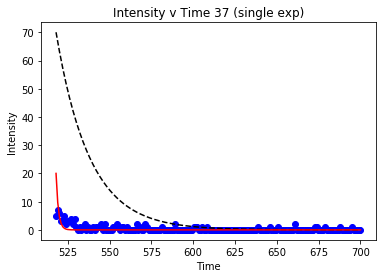

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 182
    # variables        = 2
    chi-square         = 27.0366199
    reduced chi-square = 0.15020344
    Akaike info crit   = -343.040229
    Bayesian info crit = -336.632216
[[Variables]]
    a1:    20.0000000 +/- 0.58569117 (2.93%) (init = 70)
    tau1:  0.96837353 +/- 0.14531577 (15.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.337



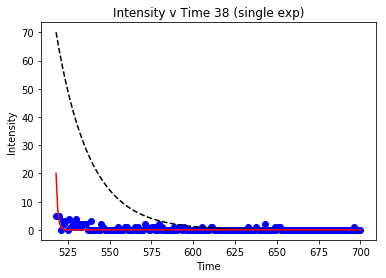

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 182
    # variables        = 2
    chi-square         = 18.5702909
    reduced chi-square = 0.10316828
    Akaike info crit   = -411.404744
    Bayesian info crit = -404.996730
[[Variables]]
    a1:    20.0000000 +/- 0.55005233 (2.75%) (init = 70)
    tau1:  0.96551042 +/- 0.12788842 (13.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.467



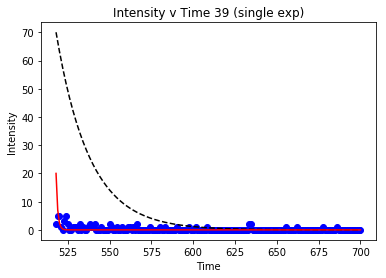

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 182
    # variables        = 2
    chi-square         = 23.0082868
    reduced chi-square = 0.12782382
    Akaike info crit   = -372.403708
    Bayesian info crit = -365.995694
[[Variables]]
    a1:    20.0000001 +/- 1.40268400 (7.01%) (init = 70)
    tau1:  1.50920583 +/- 0.21608168 (14.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, tau1) =  0.517



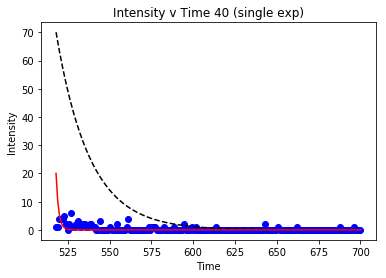

In [14]:
for i in range(1, 41, 1):
    x = xstuff #store the x data
    y = globals()["point" + str(i)] #store the y data

    def func(x, a1, tau1):
            return globals()["background" + str(i)] + a1*np.exp(-(x-518)/tau1)

    weight = [.033*n for n in y] + globals()["background" + str(i) + "std"]
    gmodel = Model(func)
    pars = Parameters()
    pars.add('a1', value = 70, min = 20, max = 120)
    pars.add('tau1', value = 20, min = 0, max = 75)
    result = gmodel.fit(y, pars, x=x, weights = weight)
    print(result.fit_report())
    plt.title("Intensity v Time " + str(i) + " (single exp)")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.plot(x, y, 'bo')
    plt.plot(x, result.init_fit, 'k--')
    plt.plot(x, result.best_fit, 'r-')
    plt.show()

182
182
0.018145161290322582
a1 = -2.4524005755955245 +/- nan
a2 = 4.564482857688098 +/- nan
tau1 = 18.844929345121564 +/- 950631.0329232326
tau2 = 18.842919648052742 +/- nan
pcov: [[-1.67062203e+15  1.67062203e+15  9.03536829e+11 -2.96277203e+11]
 [ 1.67062203e+15 -1.67062202e+15 -9.03536815e+11  2.96277209e+11]
 [ 9.03699361e+11 -9.03699346e+11  1.37446119e+09  1.16138625e+09]
 [-2.96189873e+11  2.96189879e+11  1.16131019e+09  4.85380445e+08]]
Function: y = 0.018145161290322582 + -2.452*e^(-(x-518)/18.845) + 4.564*e^(-(x-518)/18.843


C:\Users\magik\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\magik\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\magik\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


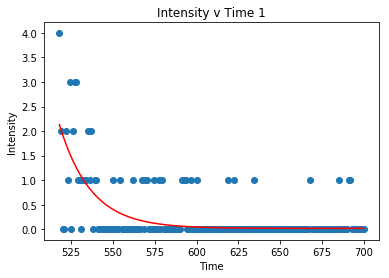

a1 = -40.71918468776501 +/- nan
a2 = 42.6642972456138 +/- nan
tau1 = 24.4259772616765 +/- 247495.4172670698
tau2 = 24.42582902911566 +/- 244926.4524248323
pcov: [[-4.39656788e+14  4.39656791e+14  6.06000904e+10  5.93648877e+10]
 [ 4.39656791e+14 -4.39656795e+14 -6.06001053e+10 -5.93649020e+10]
 [ 6.12539816e+10 -6.12539965e+10  3.09278199e+09  2.95156509e+09]
 [ 5.99889671e+10 -5.99889814e+10  2.95156736e+09  2.81679303e+09]]
Function: y = 0.020161290322580645 + -40.719*e^(-(x-518)/24.426) + 42.664*e^(-(x-518)/24.426


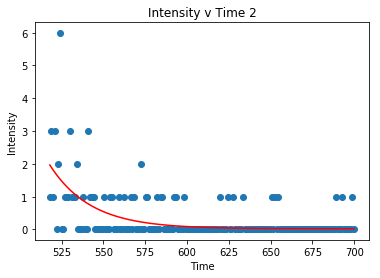

a1 = 13.947263990943307 +/- nan
a2 = -12.197865218310524 +/- nan
tau1 = 32.752665933015855 +/- 133562.50155196068
tau2 = 32.752945228460966 +/- 194645.7783206353
pcov: [[-7.63760042e+14  7.63760040e+14  1.89771645e+10  3.91884442e+10]
 [ 7.63760040e+14 -7.63760038e+14 -1.89771962e+10 -3.91884805e+10]
 [ 1.78389418e+10 -1.78389736e+10  1.87941243e+10  2.14891468e+10]
 [ 3.78869790e+10 -3.78870153e+10  2.14891207e+10  2.45701972e+10]]
Function: y = 0.02217741935483871 + 13.947*e^(-(x-518)/32.753) + -12.198*e^(-(x-518)/32.753


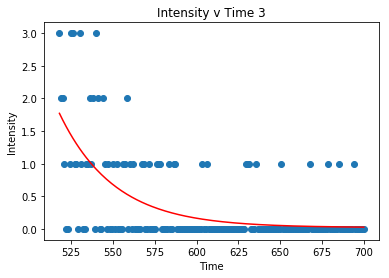

a1 = 63.86778972956771 +/- nan
a2 = -61.46733907866265 +/- nan
tau1 = 31.337844548194806 +/- 295274.7610424303
tau2 = 31.33769951269001 +/- 303837.2205425549
pcov: [[-1.03351892e+15  1.03351893e+15  8.01359304e+10  8.49904360e+10]
 [ 1.03351893e+15 -1.03351894e+15 -8.01359489e+10 -8.49904552e+10]
 [ 8.71871845e+10 -8.71872030e+10  5.75383304e+09  5.97838698e+09]
 [ 9.23170566e+10 -9.23170758e+10  5.97839875e+09  6.21171390e+09]]
Function: y = 0.014112903225806451 + 63.868*e^(-(x-518)/31.338) + -61.467*e^(-(x-518)/31.338


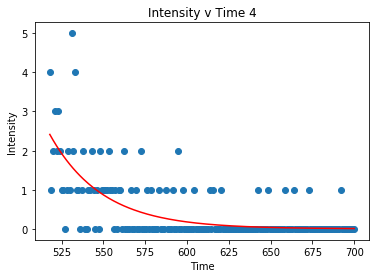

a1 = 1.761970033918566 +/- 1.3627996345847246
a2 = 2.2038879964553533 +/- 1.291107887793706
tau1 = 48.96228436444653 +/- nan
tau2 = 9.945606018680824 +/- nan
pcov: [[  1.85722284  -1.56840777 -34.42192005 -10.85944463]
 [ -1.56840777   1.66695958  29.9581785    7.49614747]
 [-34.42192005  29.9581785  719.29948906 184.9478882 ]
 [-10.85944463   7.49614747 184.9478882   81.73479278]]
Function: y = 0.02217741935483871 + 1.762*e^(-(x-518)/48.962) + 2.204*e^(-(x-518)/9.946


C:\Users\magik\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


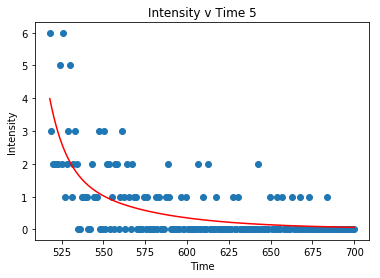

a1 = -4650.930911220552 +/- nan
a2 = 4652.811360223128 +/- nan
tau1 = 20.486778405692547 +/- 30228.868204875667
tau2 = 20.503037385559146 +/- nan
pcov: [[-5.21613010e+14  5.21613013e+14  9.13785140e+08 -9.24659967e+08]
 [ 5.21613013e+14 -5.21613016e+14 -9.13785144e+08  9.24659973e+08]
 [ 9.13784473e+08 -9.13784477e+08 -1.58925249e+03  1.63141176e+03]
 [-9.24660633e+08  9.24660640e+08  1.63141411e+03 -1.62759209e+03]]
Function: y = 0.014112903225806451 + -4650.931*e^(-(x-518)/20.487) + 4652.811*e^(-(x-518)/20.503


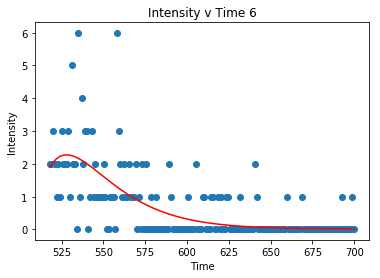

a1 = 6.074369722396571 +/- 2.809625830984908
a2 = -1.0432714518042219 +/- 2.642677942916859
tau1 = 32.04777472807482 +/- nan
tau2 = 9.03253644885479 +/- 8.025601975999118
pcov: [[   7.89399731   -7.22116697  -22.47367801   64.41028708]
 [  -7.22116697    6.98374671   20.87461851  -55.1067654 ]
 [ -22.47367801   20.87461851   69.41007075 -171.11583359]
 [  64.41028708  -55.1067654  -171.11583359  613.3046589 ]]
Function: y = 0.028225806451612902 + 6.074*e^(-(x-518)/32.048) + -1.043*e^(-(x-518)/9.033


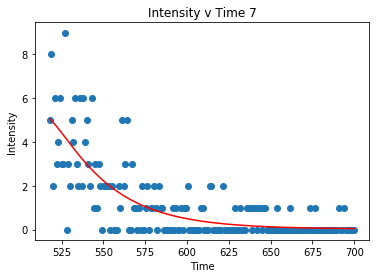

a1 = -2184.9638939091324 +/- 27793892.290342137
a2 = 2190.1767957007537 +/- 27793892.292581275
tau1 = 43.0648784727193 +/- 1800871.9054240321
tau2 = 43.064870340922795 +/- 1798727.5334771322
pcov: [[ 7.72500449e+14 -7.72500449e+14  3.84144037e+12  3.83229757e+12]
 [-7.72500448e+14  7.72500449e+14 -3.84144039e+12 -3.83229760e+12]
 [ 3.24313962e+12 -3.24313965e+12  7.53958311e+10  7.52163922e+10]
 [ 3.23542074e+12 -3.23542077e+12  7.52163919e+10  7.50373800e+10]]
Function: y = 0.014112903225806451 + -2184.964*e^(-(x-518)/43.065) + 2190.177*e^(-(x-518)/43.065


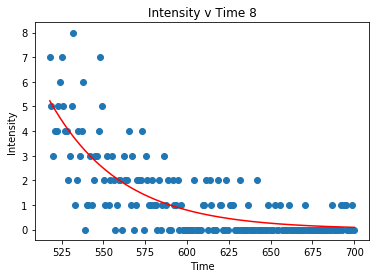

a1 = 18.07047853880282 +/- 12620060.467743438
a2 = -9.166826164559586 +/- 12620060.487797284
tau1 = 38.10989689465576 +/- nan
tau2 = 38.11367918390902 +/- 91510.59470266433
pcov: [[ 1.59265926e+14 -1.59265926e+14 -5.88118705e+09  8.29790213e+09]
 [-1.59265926e+14  1.59265927e+14  5.88119447e+09 -8.29788754e+09]
 [-5.84248799e+09  5.84249541e+09  1.12212745e+09  2.21130139e+09]
 [ 8.37418894e+09 -8.37417435e+09  2.21129656e+09  4.36013783e+09]]
Function: y = 0.046370967741935484 + 18.07*e^(-(x-518)/38.11) + -9.167*e^(-(x-518)/38.114


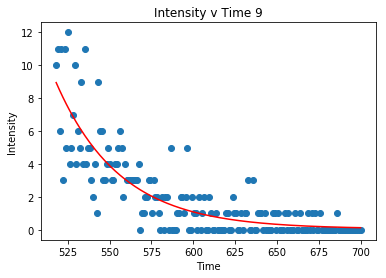

a1 = 20.20101561988493 +/- 18786039.558955498
a2 = -9.61827288271536 +/- 18786039.675444912
tau1 = 39.03057154942559 +/- 246909.20460159754
tau2 = 39.032964006835755 +/- 200629.73081918643
pcov: [[ 3.52915282e+14 -3.52915284e+14  6.09216989e+10  4.01631185e+10]
 [-3.52915284e+14  3.52915287e+14 -6.09217026e+10 -4.01631257e+10]
 [ 6.09641553e+10 -6.09641590e+10  2.34817769e+08  4.78018281e+08]
 [ 4.02522889e+10 -4.02522960e+10  4.78028842e+08  9.93982225e+08]]
Function: y = 0.04032258064516129 + 20.201*e^(-(x-518)/39.031) + -9.618*e^(-(x-518)/39.033


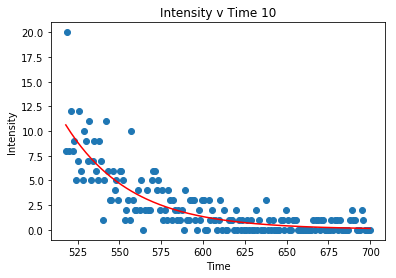

a1 = 13.505405436761276 +/- 1.9396353162764144
a2 = -1.7932260100798842 +/- 1.8201052418758386
tau1 = 36.49557863010079 +/- nan
tau2 = 8.665799103201817 +/- 4.521522235887225
pcov: [[  3.76218516  -3.31877297  -6.13599788  20.44416333]
 [ -3.31877297   3.31278309   5.53621801 -15.96037029]
 [ -6.13599788   5.53621801  11.10802216 -30.77723894]
 [ 20.44416333 -15.96037029 -30.77723894 136.51539841]]
Function: y = 0.03024193548387097 + 13.505*e^(-(x-518)/36.496) + -1.793*e^(-(x-518)/8.666


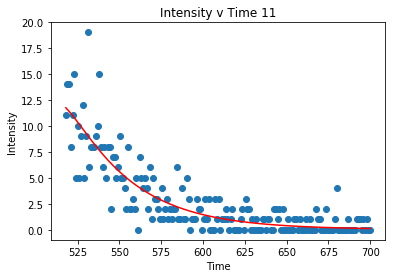

C:\Users\magik\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
C:\Users\magik\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


a1 = 17.841861500936755 +/- inf
a2 = -3.874119565451975 +/- inf
tau1 = 37.45901186498824 +/- inf
tau2 = 0.04514916081176507 +/- inf
pcov: [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
Function: y = 0.03225806451612903 + 17.842*e^(-(x-518)/37.459) + -3.874*e^(-(x-518)/0.045


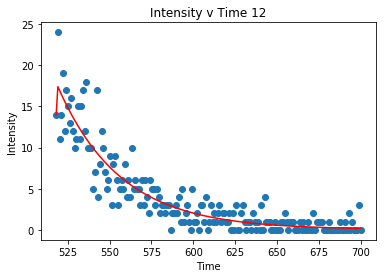

a1 = 27.49250092790957 +/- 1.0537639836936528
a2 = 1.030857528754116 +/- 1.172420958640904
tau1 = 28.410053452990983 +/- 1.2038097998117603
tau2 = 287.47082020379713 +/- 25.119666568633964
pcov: [[ 1.11041853e+00 -1.15489802e+00  1.44915803e+00  6.30997649e+02]
 [-1.15489802e+00  1.37457090e+00 -1.92136969e+00 -7.39536008e+02]
 [ 1.44915803e+00 -1.92136969e+00  3.08020697e+00  9.99369575e+02]
 [ 6.30997649e+02 -7.39536008e+02  9.99369575e+02  4.09405003e+05]]
Function: y = 0.04233870967741935 + 27.493*e^(-(x-518)/28.41) + 1.031*e^(-(x-518)/287.471


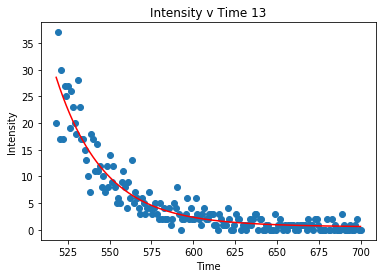

a1 = 35.546938307331445 +/- 1.4706324092414018
a2 = 2.5125782263311187 +/- 1.6115908692664809
tau1 = 25.573037565135955 +/- 1.3156569679550951
tau2 = 143.21819753783615 +/- 11.429526476096997
pcov: [[ 2.16275968e+00 -2.28357858e+00  1.73095326e+00  1.30634075e+02]
 [-2.28357858e+00  2.59722513e+00 -2.11588939e+00 -1.46708783e+02]
 [ 1.73095326e+00 -2.11588939e+00  1.94567477e+00  1.15190635e+02]
 [ 1.30634075e+02 -1.46708783e+02  1.15190635e+02  8.57436593e+03]]
Function: y = 0.034274193548387094 + 35.547*e^(-(x-518)/25.573) + 2.513*e^(-(x-518)/143.218


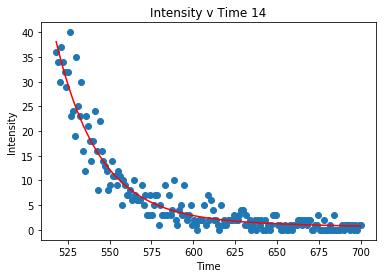

a1 = 61.39121967545669 +/- 1.0132653436167574
a2 = 2.976797725784923 +/- 1.111907794453184
tau1 = 21.897573387932162 +/- 0.6528665932256472
tau2 = 152.55923739046943 +/- 7.812178761071305
pcov: [[ 1.02670666e+00 -1.02623243e+00  4.26234789e-01  6.10301370e+01]
 [-1.02623243e+00  1.23633894e+00 -5.96398920e-01 -7.20636070e+01]
 [ 4.26234789e-01 -5.96398920e-01  3.43846346e-01  3.32176675e+01]
 [ 6.10301370e+01 -7.20636070e+01  3.32176675e+01  4.40876558e+03]]
Function: y = 0.06854838709677419 + 61.391*e^(-(x-518)/21.898) + 2.977*e^(-(x-518)/152.559


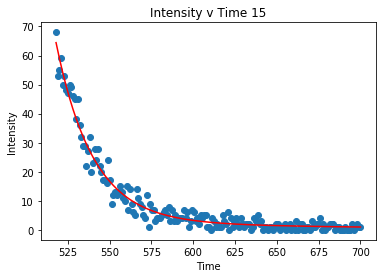

a1 = -20.145596443214977 +/- 17585817.588807393
a2 = 95.81361809785534 +/- 17585817.552781735
tau1 = 24.120334284138583 +/- 185465.2674539823
tau2 = 24.118829759839716 +/- 92657.77245420494
pcov: [[ 3.09260980e+14 -3.09260980e+14  3.40976315e+10  8.52243906e+09]
 [-3.09260980e+14  3.09260979e+14 -3.40976213e+10 -8.52243691e+09]
 [ 3.43973654e+10 -3.43973552e+10  1.52698176e+09  3.21222236e+08]
 [ 8.58546280e+09 -8.58546064e+09  3.21220925e+08  6.75792738e+07]]
Function: y = 0.07258064516129033 + -20.146*e^(-(x-518)/24.12) + 95.814*e^(-(x-518)/24.119


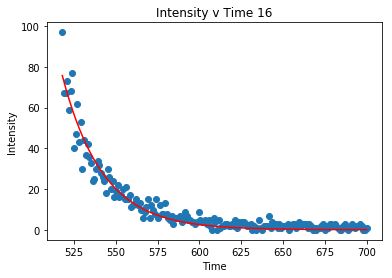

a1 = 12.15795927410473 +/- 1.346270023022584
a2 = 84.70284850455091 +/- 1.2465321816308743
tau1 = 75.09078225928435 +/- nan
tau2 = 15.301546428771216 +/- nan
pcov: [[ 1.81244297 -1.54326446 -8.06236821 -0.4045285 ]
 [-1.54326446  1.55384248  7.02833348  0.29672995]
 [-8.06236821  7.02833348 38.95696359  1.68546847]
 [-0.4045285   0.29672995  1.68546847  0.11059163]]
Function: y = 0.07056451612903226 + 12.158*e^(-(x-518)/75.091) + 84.703*e^(-(x-518)/15.302


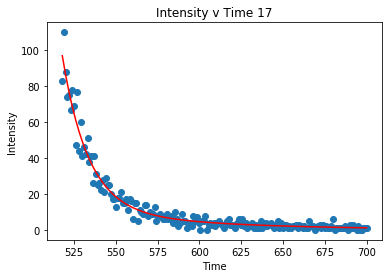

a1 = 103.12319892027517 +/- 1.255656357155869
a2 = 25.870186432541086 +/- 1.3308751036825863
tau1 = 10.950424518847631 +/- 0.41032667792559513
tau2 = 53.9780135119581 +/- 1.471497474727773
pcov: [[ 1.57667289 -1.49387237  0.16836798  2.16530482]
 [-1.49387237  1.77122854 -0.24292997 -2.49278262]
 [ 0.16836798 -0.24292997  0.04259865  0.31511298]
 [ 2.16530482 -2.49278262  0.31511298  3.93226918]]
Function: y = 0.09879032258064516 + 103.123*e^(-(x-518)/10.95) + 25.87*e^(-(x-518)/53.978


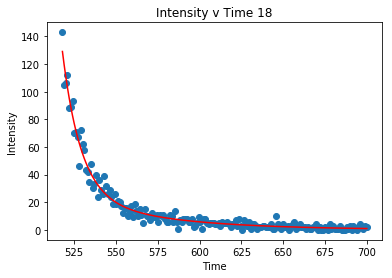

a1 = 34.525610315653765 +/- 1.485064542989301
a2 = 93.44155064190767 +/- 1.4018073824807937
tau1 = 45.06606727139254 +/- nan
tau2 = 9.527210633645286 +/- nan
pcov: [[ 2.2054167  -1.88433193 -1.86882602 -0.28173124]
 [-1.88433193  1.96506394  1.64257295  0.20124036]
 [-1.86882602  1.64257295  1.78047629  0.21944451]
 [-0.28173124  0.20124036  0.21944451  0.04582209]]
Function: y = 0.09274193548387097 + 34.526*e^(-(x-518)/45.066) + 93.442*e^(-(x-518)/9.527


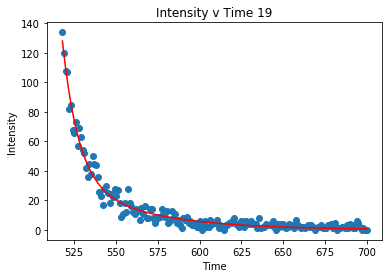

a1 = 20.12010126506036 +/- 1.2368074653566892
a2 = 94.4482475975894 +/- 1.1671387912795426
tau1 = 61.02626106199292 +/- nan
tau2 = 11.920223995861617 +/- nan
pcov: [[ 1.52969271 -1.27776622 -3.25050638 -0.25534389]
 [-1.27776622  1.36221296  2.79790453  0.17301257]
 [-3.25050638  2.79790453  7.71377005  0.50145782]
 [-0.25534389  0.17301257  0.50145782  0.05463568]]
Function: y = 0.07459677419354839 + 20.12*e^(-(x-518)/61.026) + 94.448*e^(-(x-518)/11.92


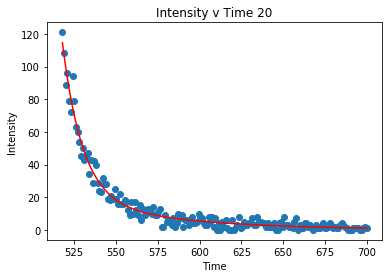

a1 = 81.02835364441214 +/- 1.837672058447482
a2 = 27.73779662030489 +/- 1.969821888312986
tau1 = 11.136450711668559 +/- 0.6763748147700654
tau2 = 44.60792583817746 +/- 1.8251367273257837
pcov: [[ 3.37703859 -3.44610008  0.45748289  3.33112407]
 [-3.44610008  3.88019827 -0.57052863 -3.67557487]
 [ 0.45748289 -0.57052863  0.10082078  0.50199572]
 [ 3.33112407 -3.67557487  0.50199572  3.81655466]]
Function: y = 0.06653225806451613 + 81.028*e^(-(x-518)/11.136) + 27.738*e^(-(x-518)/44.608


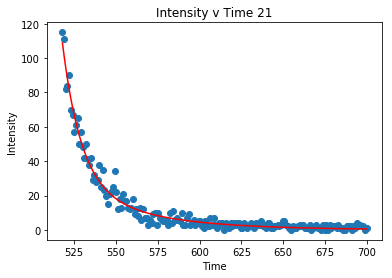

a1 = 28.376070804500536 +/- 1.6429813480908875
a2 = 64.58004526646496 +/- 1.5521453614651084
tau1 = 38.36180914622819 +/- nan
tau2 = 8.330257516380685 +/- nan
pcov: [[ 2.69938771 -2.33176468 -2.32014585 -0.42576915]
 [-2.33176468  2.40915522  2.05867196  0.3120766 ]
 [-2.32014585  2.05867196  2.24281182  0.33609395]
 [-0.42576915  0.3120766   0.33609395  0.08508617]]
Function: y = 0.05040322580645161 + 28.376*e^(-(x-518)/38.362) + 64.58*e^(-(x-518)/8.33


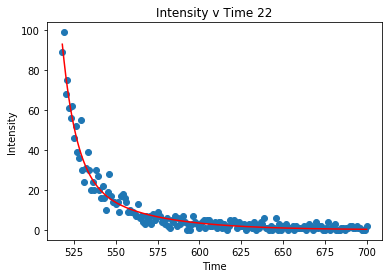

a1 = 53.23827296463596 +/- 1.351294494203806
a2 = 31.89089127560682 +/- 1.37311510015646
tau1 = 5.943198154441169 +/- 0.4353202474024294
tau2 = 32.60782361214733 +/- 1.0770591096134343
pcov: [[ 1.82599681 -1.58028726  0.18950372  1.16005633]
 [-1.58028726  1.88544508 -0.29669622 -1.33799514]
 [ 0.18950372 -0.29669622  0.06350138  0.19149831]
 [ 1.16005633 -1.33799514  0.19149831  1.10290954]]
Function: y = 0.046370967741935484 + 53.238*e^(-(x-518)/5.943) + 31.891*e^(-(x-518)/32.608


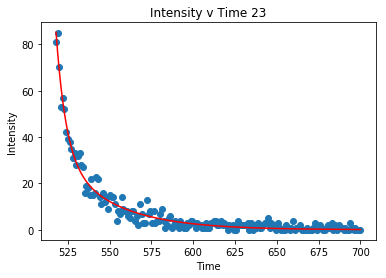

a1 = 40.804096419679865 +/- 1.1211459106407884
a2 = 5.808672823447677 +/- 1.2029161048247137
tau1 = 14.753508885316927 +/- 0.6898848050975981
tau2 = 77.75488430439393 +/- 3.5412074772564663
pcov: [[  1.25696815  -1.20923529   0.47594104  12.5401504 ]
 [ -1.20923529   1.44700716  -0.68556424 -14.61236994]
 [  0.47594104  -0.68556424   0.40653225   6.46794773]
 [ 12.5401504  -14.61236994   6.46794773 161.38252834]]
Function: y = 0.034274193548387094 + 40.804*e^(-(x-518)/14.754) + 5.809*e^(-(x-518)/77.755


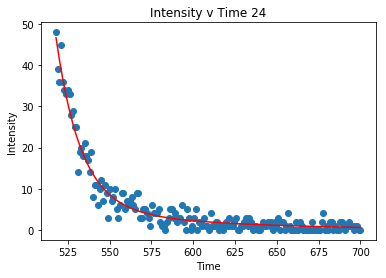

a1 = 24.836342769909596 +/- 1.3182413745328714
a2 = 4.535715934924756 +/- 1.4260196578293332
tau1 = 15.514925217551033 +/- 1.0697975100331556
tau2 = 73.490778063253 +/- 4.508402446355411
pcov: [[  1.73776032  -1.74670179   1.14446671  20.32569262]
 [ -1.74670179   2.03353206  -1.5238433  -23.1450167 ]
 [  1.14446671  -1.5238433    1.38527356  16.26325718]
 [ 20.32569262 -23.1450167   16.26325718 285.32387021]]
Function: y = 0.024193548387096774 + 24.836*e^(-(x-518)/15.515) + 4.536*e^(-(x-518)/73.491


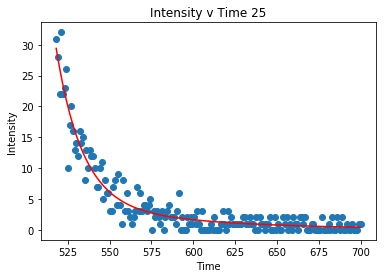

a1 = -95327.18719948085 +/- nan
a2 = 95334.6531842279 +/- nan
tau1 = -604658.9166413674 +/- nan
tau2 = -912620.1212379624 +/- 5510482.920276562
pcov: [[-4.99236620e+13  4.99236621e+13 -9.35399251e+13  3.03264191e+13]
 [ 4.99236621e+13 -4.99236622e+13  9.35399254e+13 -3.03264189e+13]
 [-9.35228037e+13  9.35228040e+13  1.08630332e+15  2.93061238e+15]
 [ 3.03654220e+13 -3.03654218e+13  2.93069586e+15  6.52813981e+15]]
Function: y = 0.018145161290322582 + -95327.187*e^(-(x-518)/-604658.917) + 95334.653*e^(-(x-518)/-912620.121


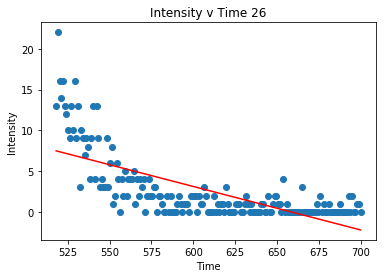

a1 = 4.757710957008763 +/- 1.6507456936594194
a2 = 14.435982641447087 +/- 1.53874461455607
tau1 = 51.0800933504677 +/- nan
tau2 = 11.753816476251032 +/- nan
pcov: [[  2.72496135  -2.37308539 -18.29397951  -2.55867583]
 [ -2.37308539   2.36773499  16.30799345   1.95549313]
 [-18.29397951  16.30799345 135.40063792  15.92749246]
 [ -2.55867583   1.95549313  15.92749246   2.94477093]]
Function: y = 0.02217741935483871 + 4.758*e^(-(x-518)/51.08) + 14.436*e^(-(x-518)/11.754


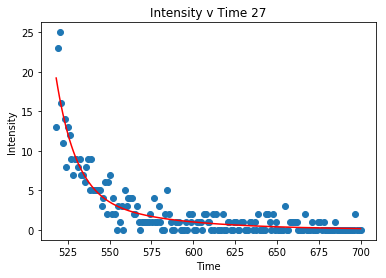

a1 = 0.3593713545022074 +/- 0.5065373555486103
a2 = 11.395728386993605 +/- 0.5278086628039622
tau1 = 10679824.63382006 +/- nan
tau2 = 22.942608815343792 +/- nan
pcov: [[ 2.56580093e-01 -1.71044995e-01 -3.85107603e+11 -1.06021649e+00]
 [-1.71044995e-01  2.78581985e-01  2.66560118e+11  3.58956381e-01]
 [-3.85107603e+11  2.66560118e+11  6.03799577e+23  1.52766266e+12]
 [-1.06021649e+00  3.58956381e-01  1.52766266e+12  5.89959642e+00]]
Function: y = 0.016129032258064516 + 0.359*e^(-(x-518)/10679824.634) + 11.396*e^(-(x-518)/22.943


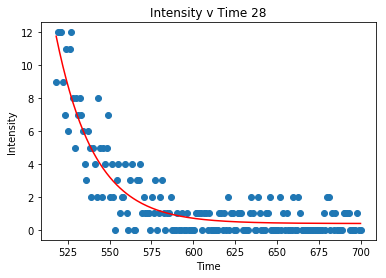

a1 = -3.796687845100741 +/- 21864112.828782227
a2 = 12.197507250889128 +/- 21864112.820289522
tau1 = 24.569746714442736 +/- nan
tau2 = 24.571864058870766 +/- 235627.21547849211
pcov: [[ 4.78039430e+14 -4.78039430e+14 -8.82169154e+10  5.55229383e+10]
 [-4.78039430e+14  4.78039429e+14  8.82169263e+10 -5.55229349e+10]
 [-8.82257617e+10  8.82257726e+10  1.79721383e+09  5.44101260e+08]
 [ 5.55201847e+10 -5.55201813e+10  5.44102795e+08  1.78999775e+08]]
Function: y = 0.020161290322580645 + -3.797*e^(-(x-518)/24.57) + 12.198*e^(-(x-518)/24.572


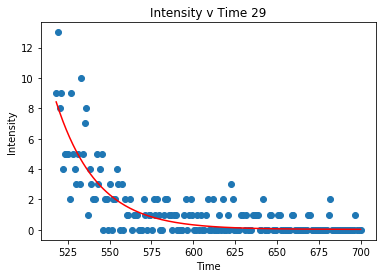

a1 = 6.840321975388164 +/- 0.5318805165274615
a2 = 0.28770183490869017 +/- 0.5155626664090468
tau1 = 23.218075421692284 +/- 0.8089701416747027
tau2 = -830494.0586805819 +/- 45094.07022513153
pcov: [[ 2.82896884e-01 -1.78579131e-01  6.54432690e-01  2.03347517e+09]
 [-1.78579131e-01  2.65804863e-01 -1.83974194e+00 -2.91757212e+09]
 [ 6.54432690e-01 -1.83974194e+00  1.70171210e+01  1.93956574e+10]
 [ 2.03347517e+09 -2.91757212e+09  1.93956574e+10  3.34169623e+19]]
Function: y = 0.018145161290322582 + 6.84*e^(-(x-518)/23.218) + 0.288*e^(-(x-518)/-830494.059


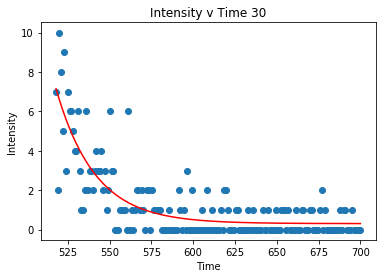

a1 = 6.1761455611551614 +/- 0.3448646783038122
a2 = 0.004767294733480668 +/- 0.052734090280929874
tau1 = 33.66849664872844 +/- nan
tau2 = -50.80973666949562 +/- nan
pcov: [[ 1.18931646e-01  3.47562278e-03 -8.06124093e-01 -1.05450891e+01]
 [ 3.47562278e-03  2.78088428e-03 -1.31720967e-01 -9.10291743e+00]
 [-8.06124093e-01 -1.31720967e-01  1.35242148e+01  4.19435362e+02]
 [-1.05450891e+01 -9.10291743e+00  4.19435362e+02  3.01648337e+04]]
Function: y = 0.018145161290322582 + 6.176*e^(-(x-518)/33.668) + 0.005*e^(-(x-518)/-50.81


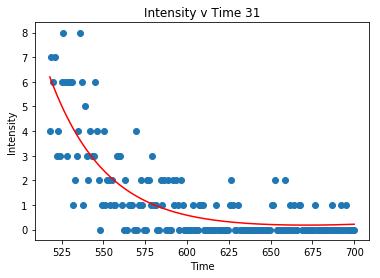

a1 = 7.486668188968064 +/- 1.1859571471366668
a2 = -3.9127017878324732 +/- 1.2688640222438456
tau1 = 26.090902639617084 +/- nan
tau2 = 3.84920612570218 +/- 1.4957847747761754
pcov: [[ 1.40649435 -1.15898728 -3.72117148  2.23737209]
 [-1.15898728  1.61001591  3.18437861 -1.18753541]
 [-3.72117148  3.18437861 11.92408444 -5.34738237]
 [ 2.23737209 -1.18753541 -5.34738237  5.32800758]]
Function: y = 0.020161290322580645 + 7.487*e^(-(x-518)/26.091) + -3.913*e^(-(x-518)/3.849


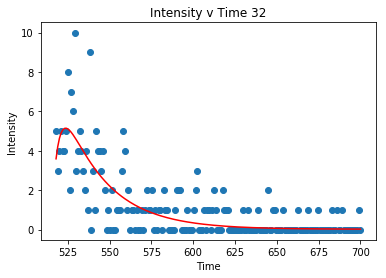

a1 = 33181.036566713854 +/- 8258437.067287699
a2 = -33178.572738527546 +/- 8258437.086793792
tau1 = -495550.7894276268 +/- 9747917.7840273
tau2 = -392438.7842715374 +/- nan
pcov: [[ 6.82017828e+13 -6.82017830e+13  9.49878519e+13 -1.08277604e+14]
 [-6.82017830e+13  6.82017831e+13 -9.49878562e+13  1.08277602e+14]
 [ 9.50219011e+13 -9.50219054e+13  9.90079937e+15  5.97520141e+15]
 [-1.08256251e+14  1.08256249e+14  5.97528520e+15  4.01368222e+15]]
Function: y = 0.016129032258064516 + 33181.037*e^(-(x-518)/-495550.789) + -33178.573*e^(-(x-518)/-392438.784


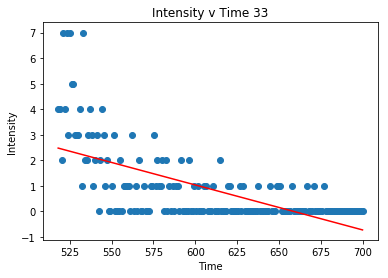

a1 = 1.06622764067486 +/- 2.0384108427294687
a2 = 4.571974275149267 +/- 1.8926533549257667
tau1 = 60.86717058741768 +/- nan
tau2 = 15.759803125159277 +/- nan
pcov: [[ 4.15511876e+00 -3.72807597e+00 -1.42411990e+02 -1.44230522e+01]
 [-3.72807597e+00  3.58213672e+00  1.29823245e+02  1.19962255e+01]
 [-1.42411990e+02  1.29823245e+02  5.22770026e+03  4.65645248e+02]
 [-1.44230522e+01  1.19962255e+01  4.65645248e+02  5.81382794e+01]]
Function: y = 0.03225806451612903 + 1.066*e^(-(x-518)/60.867) + 4.572*e^(-(x-518)/15.76


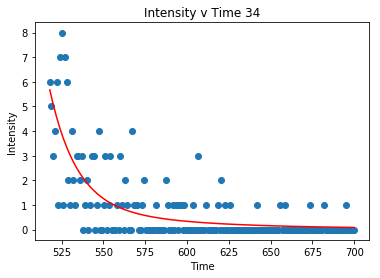

a1 = 0.1448614185680252 +/- 0.7560929128008692
a2 = 3.214421272737984 +/- 0.6832367904993358
tau1 = 1104888.0480390538 +/- nan
tau2 = 29.725154888158333 +/- nan
pcov: [[ 5.71676493e-01 -4.36811196e-01 -2.02043689e+10 -9.10227808e+00]
 [-4.36811196e-01  4.66812512e-01  1.57890044e+10  5.59107703e+00]
 [-2.02043689e+10  1.57890044e+10  7.33149096e+20  3.11192230e+11]
 [-9.10227808e+00  5.59107703e+00  3.11192230e+11  1.73109598e+02]]
Function: y = 0.012096774193548387 + 0.145*e^(-(x-518)/1104888.048) + 3.214*e^(-(x-518)/29.725


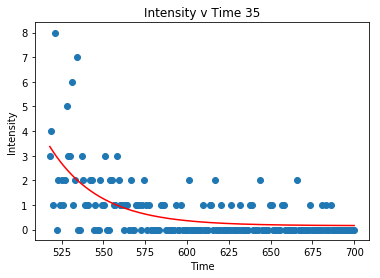

a1 = 44.257890871211245 +/- 1136512.941000961
a2 = -41.41231675799711 +/- 1136512.6996257883
tau1 = 27.67693904170183 +/- nan
tau2 = 27.247214175193818 +/- 82366.62684081198
pcov: [[ 1.29166167e+12 -1.29166139e+12 -6.39821982e+09  6.78426122e+09]
 [-1.29166139e+12  1.29166112e+12  6.39821846e+09 -6.78425977e+09]
 [-6.39821982e+09  6.39821846e+09  3.16939011e+07 -3.36052201e+07]
 [ 6.78426122e+09 -6.78425977e+09 -3.36052201e+07  3.56338383e+07]]
Function: y = 0.024193548387096774 + 44.258*e^(-(x-518)/27.677) + -41.412*e^(-(x-518)/27.247


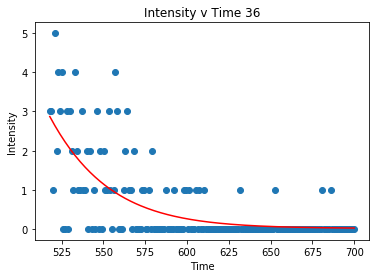

a1 = 6084.844668443324 +/- 21259766.944644563
a2 = -6079.009397197904 +/- 21259765.581592824
tau1 = 10.699775936471772 +/- nan
tau2 = 10.699775904445557 +/- nan
pcov: [[ 4.51977691e+14 -4.51977679e+14 -2.59501439e+12 -2.59750533e+12]
 [-4.51977644e+14  4.51977633e+14  2.59501438e+12  2.59750532e+12]
 [-4.31160346e+12  4.31160345e+12  3.02278701e+08  3.02568830e+08]
 [-4.31574215e+12  4.31574214e+12  3.02568841e+08  3.02859249e+08]]
Function: y = 0.014112903225806451 + 6084.845*e^(-(x-518)/10.7) + -6079.009*e^(-(x-518)/10.7


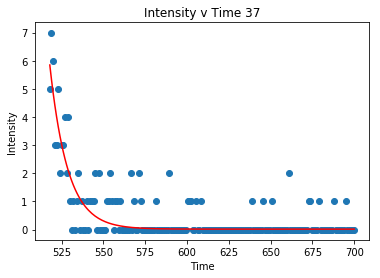

a1 = 0.6579917870412445 +/- 0.6961078531412137
a2 = 3.865470056695634 +/- 0.8061376826792985
tau1 = 66.0511220236612 +/- nan
tau2 = 8.203720285797584 +/- nan
pcov: [[ 4.84566143e-01 -3.53659028e-01 -4.14591984e+01 -1.88933154e+00]
 [-3.53659028e-01  6.49857963e-01  3.19962029e+01  5.26091221e-01]
 [-4.14591984e+01  3.19962029e+01  4.27415619e+03  1.47230103e+02]
 [-1.88933154e+00  5.26091221e-01  1.47230103e+02  1.15885385e+01]]
Function: y = 0.028225806451612902 + 0.658*e^(-(x-518)/66.051) + 3.865*e^(-(x-518)/8.204


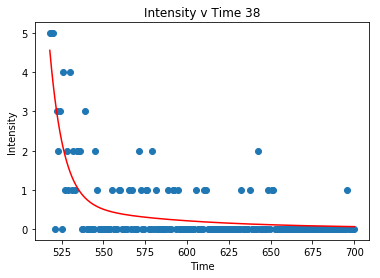

a1 = 0.6967228230022183 +/- 0.6555983654032225
a2 = 3.0318382333416594 +/- 0.8316617180608592
tau1 = 56.85861926513427 +/- nan
tau2 = 6.382925562520923 +/- nan
pcov: [[ 4.29809217e-01 -3.07906861e-01 -2.99502940e+01 -1.77051940e+00]
 [-3.07906861e-01  6.91661213e-01  2.28131340e+01  2.62100240e-01]
 [-2.99502940e+01  2.28131340e+01  2.61019278e+03  1.11729980e+02]
 [-1.77051940e+00  2.62100240e-01  1.11729980e+02  1.23824424e+01]]
Function: y = 0.014112903225806451 + 0.697*e^(-(x-518)/56.859) + 3.032*e^(-(x-518)/6.383


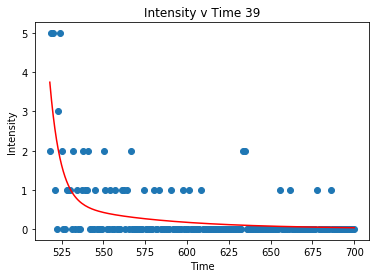

In [15]:
x = xstuff #store the x data
y = globals()["point" + str(1)] #store the y dataprint(len(y))
print(len(y))
print(len(x))
print(background1)
for i in range(1, 40, 1):
    init = (globals()["data1d_" + str(518)][i] + globals()["data1d_" + str(519)][i])/2
    x = xstuff #store the x data
    y = globals()["point" + str(i)] #store the y data

    #define the function you would like to fit to
    def func(x, a1, a2, tau1, tau2):
        return globals()["background" + str(i)] + a1*np.exp(-(x-518)/tau1) + a2*np.exp(-(x-518)/tau2)
    #store values from curve fit, give it (function, x vals, y vals, [initial vals of function constants])
    popt, pcov = curve_fit(func, x, y, [50, 50, 25, 25], absolute_sigma = True)
    #print function in an easy to read way
    print("a1 =", popt[0], "+/-", pcov[0,0]**0.5)
    print("a2 =", popt[1], "+/-", pcov[1,1]**0.5)
    print("tau1 =", popt[2], "+/-", pcov[2,0]**0.5)
    print("tau2 =", popt[3], "+/-", pcov[3,0]**0.5)
    print("pcov: " + str(pcov))
    print("Function: y = " + str(globals()["background" + str(i)]) + " + " + str(round(popt[0], 3)) + "*e^" +  "(-(x-" + str(518) + ")/" + str(round(popt[2], 3)) + ") + " + str(round(popt[1], 3)) + "*e^" +  "(-(x-" + str(518) + ")/" + str(round(popt[3], 3)))
    #plot orgiginal data and fitted function
    scatter(x,y)
    #plt.errorbar(x, y, yerr=e, fmt="none")
    plt.title("Intensity v Time " + str(i))
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plot(x,func(x,*popt), 'r')
    show()

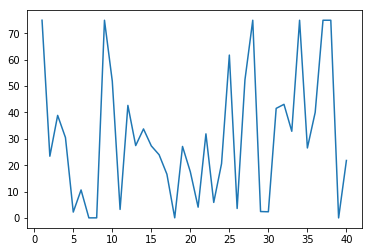

In [16]:
x_coeff = np.linspace(1, 40, 40)
plt.plot(x_coeff, tau2TimeDoubleExp)